<a href="https://colab.research.google.com/github/Kassra-sinaei/NAO_Sim/blob/Gait_A2CC/RL_Gait.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Full Body Trajectory for Walking
**Implmentation of an A2C Agent for learning Biped Gait** 

Getting google colab ready...

In [ ]:
#Remove Cuda 11.2 
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

#installing CUDA 11.1
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64/cuda-ubuntu1604.pin
!sudo mv cuda-ubuntu1604.pin /etc/apt/preferences.d/cuda-repository-pin-600
!wget https://developer.download.nvidia.com/compute/cuda/11.1.0/local_installers/cuda-repo-ubuntu1604-11-1-local_11.1.0-455.23.05-1_amd64.deb
!sudo dpkg -i cuda-repo-ubuntu1604-11-1-local_11.1.0-455.23.05-1_amd64.deb
!sudo apt-key add /var/cuda-repo-ubuntu1604-11-1-local/7fa2af80.pub
!sudo apt-get update
!sudo apt-get -y install cuda

# check if installed successfully
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

dpkg: dependency problems prevent removal of cuda-cublas-10-0:
 cuda-cublas-dev-10-0 depends on cuda-cublas-10-0 (>= 10.0.130).

dpkg: error processing package cuda-cublas-10-0 (--purge):
 dependency problems - not removing
Errors were encountered while processing:
 cuda-cublas-10-0
(Reading database ... 122489 files and directories currently installed.)
Removing cuda-cublas-dev-10-0 (10.0.130-1) ...
dpkg: dependency problems prevent removal of cuda-cudart-10-0:
 cuda-cudart-dev-10-0 depends on cuda-cudart-10-0 (>= 10.0.130).

dpkg: error processing package cuda-cudart-10-0 (--purge):
 dependency problems - not removing
Errors were encountered while processing:
 cuda-cudart-10-0
dpkg: dependency problems prevent removal of cuda-cudart-10-1:
 cuda-cudart-dev-10-1 depends on cuda-cudart-10-1 (>= 10.1.243).

dpkg: error processing package cuda-cudart-10-1 (--purge):
 dependency problems - not removing
Errors were encountered while processing:
 cuda-cudart-10-1
(Reading database ... 122476

In [2]:
!pip install pybullet
!pip install qibullet

#!pip install coax
!git clone https://github.com/microsoft/coax.git
!pip install -e ./coax

%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0

     |████████████████████████████████| 76.6MB 43kB/s 
     |████████████████████████████████| 5.8MB 5.5MB/s 
Cloning into 'coax'...
remote: Enumerating objects: 214, done.
remote: Counting objects: 100% (214/214), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 3909 (delta 97), reused 90 (delta 36), pack-reused 3695
Receiving objects: 100% (3909/3909), 10.09 MiB | 9.95 MiB/s, done.
Resolving deltas: 100% (2919/2919), done.
Checking out files: 100% (347/347), done.
Obtaining file:///content/drive/My%20Drive/Colab%20Notebooks/coax
     |████████████████████████████████| 266kB 9.1MB/s 
     |████████████████████████████████| 51kB 9.5MB/s 
     |████████████████████████████████| 61kB 10.5MB/s 
     |████████████████████████████████| 317kB 26.2MB/s 
     |████████████████████████████████| 1.8MB 37.8MB/s 
     |████████████████████████████████| 47.5MB 147kB/s 
     |████████████████████████████████| 81kB 14.2MB/s 
     |████████████████████████████████| 1.3MB 51.0MB/s

Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [1]:
%cd /content/drive/My Drive/Colab Notebooks
import pybullet
import time
import pybullet_data
import numpy as np
import matplotlib.pyplot as plt

import gym
from gym import spaces

from qibullet import SimulationManager
from qibullet import NaoVirtual
#import tensorflow.contrib

import lz4.frame
import cloudpickle as pickle

from PIL import Image
from IPython.display import display

/content/drive/My Drive/Colab Notebooks


GYM Based Environment

In [2]:
class NAO(gym.Env):
    #metadata = {'render.modes': ['human']}

    def __init__(self,imu_freq = 240,max_episode_length = 10000):
        super(NAO, self).__init__()
        # Define action and observation space
        self.action_space = spaces.Box(low=np.array([-1.53589,-1.14529,-0.379435,-0.0923279,-1.18944,-0.397761, 
                                                    -1.53589,-1.14529,-0.79046,-0.0923279,-1.1863,-0.768992]),
                                       high=np.array([0.48398,0.740718,0.79046,2.11255,0.922581,0.768992,
                                                     0.48398,0.740718,0.379435,2.11255,0.932006,0.397761]))
        self.observation_space = spaces.Box(low=np.array([-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10]), 
                                            high=np.array([10,10,10,10,10,10,10,10,10,10,10,10])) 
        """""""""""""""""""""
            Action Space: 12 component for lower limb joint positions
                          LHipPitch,LHipYawPitch,LHipRoll,LKneePitch,LAnklePitch,LAnkleRoll
                          RHipPitch,RHipYawPitch,RHipRoll,RKneePitch,RAnklePitch,RAnkleRoll
        """"""""""""""""""
            Observation Space: LPelvis,RPelvis Poition (z component), 
                               Torso Orientation (y component),
                               Toros's linear velocity (normal x & y component)
        """""""""""""""""""""

        #Instantiate Phisycs Client
        self.phisycsClient = pybullet.connect(pybullet.DIRECT)
        pybullet.setAdditionalSearchPath(pybullet_data.getDataPath())
        
        self.previous_config = np.array([0]*12)
        self.max_steps = max_episode_length
        self.steps = 0
        self.imu_freq = imu_freq
        
        self.velocity_x = 0
        self.simulation_manager = None
        self.imu = None
        self.nao = None
        self.reset()
        self.effort = 1.0
        
    def step(self,action):
        self.take_action(action)
        obs = self.observe()
        reward = self.calculate_reward(obs,action,)
        done = self.is_terminated(obs)
        return obs, reward, done, {}
    
    def take_action(self,action):
        self.previous_config = self.nao.getAnglesPosition(["LHipPitch","LHipYawPitch","LHipRoll","LKneePitch","LAnklePitch","LAnkleRoll",
                                                           "RHipPitch","RHipYawPitch","RHipRoll","RKneePitch","RAnklePitch","RAnkleRoll"])

        self.nao.setAngles("LHipPitch",float(action[0]),self.effort)
        self.nao.setAngles("LHipYawPitch",float(action[1]),self.effort)
        self.nao.setAngles("LHipRoll",float(action[2]),self.effort)
        self.nao.setAngles("LKneePitch",float(action[3]),self.effort)
        self.nao.setAngles("LAnklePitch",float(action[4]),self.effort)
        self.nao.setAngles("LAnkleRoll",float(action[5]),self.effort)
        self.nao.setAngles("RHipPitch",float(action[6]),self.effort)
        self.nao.setAngles("RHipYawPitch",float(action[7]),self.effort)
        self.nao.setAngles("RHipRoll",float(action[8]),self.effort)
        self.nao.setAngles("RKneePitch",float(action[9]),self.effort)
        self.nao.setAngles("RAnklePitch",float(action[10]),self.effort)
        self.nao.setAngles("RAnkleRoll",float(action[11]),self.effort)
        pybullet.stepSimulation()

        if np.random.rand() < 0.06:
            self.disp()
        
        pass
    
    def calculate_reward(self,obs,action):
        velx,yaw,pitch,roll,height,x,r_sole_x,r_sole_y,r_sole_z,l_sole_x,l_sole_y,l_sole_z = obs
        #print (velx," ",yaw," ",pitch," ",roll," ",height)
        deltaTheta = action - self.previous_config
        reward = 50 * velx - abs(yaw * 10) - abs(pitch * 10) - abs(roll * 10) - 10 * abs(height - 0.25) + \
                    40 * x - abs(np.sum(deltaTheta)) - \
                    20 * (abs(r_sole_x)+abs(r_sole_y)+abs(r_sole_z)+abs(l_sole_x)+abs(l_sole_y)+abs(l_sole_z))
        #print (2 * velx," ",yaw * 100," ",pitch * 100," ",roll * 100," ",(height - 0.25)**2, " ", 10 * np.sum(deltaTheta), " ",x)
        if self.is_terminated():
            reward -= 50
        return reward
    
    def observe(self):
        _, linear_acceleration = self.nao.getImuValues()
        a = linear_acceleration[0]
        self.velocity_x += (1/self.imu_freq) * a 
        
        torsoYaw = pybullet.getEulerFromQuaternion(self.nao.getLinkPosition("torso")[1])[2]
        torsoPitch = pybullet.getEulerFromQuaternion(self.nao.getLinkPosition("torso")[1])[1]
        torsoRoll = pybullet.getEulerFromQuaternion(self.nao.getLinkPosition("torso")[1])[0]
        
        Lpelvis,_ = self.nao.getLinkPosition("LPelvis")
        Rpelvis,_ = self.nao.getLinkPosition("RPelvis")
        pelvisHeight = 0.5*(Lpelvis[2] + Rpelvis[2])  
        
        x, y, theta = self.nao.getPosition()
        
        r_sole = pybullet.getEulerFromQuaternion(self.nao.getLinkPosition("r_sole")[1])
        l_sole = pybullet.getEulerFromQuaternion(self.nao.getLinkPosition("l_sole")[1])
        
        return np.array([self.velocity_x,torsoYaw , torsoPitch, torsoRoll, pelvisHeight,x,
                         r_sole[0],r_sole[1],r_sole[2],l_sole[0],l_sole[0],l_sole[0]])
    
    def is_terminated(self,obs):
        if self.steps == self.max_steps:
            self.steps = 0
            self.reset()
            return True
        elif abs(obs[1]) > 15 *(np.pi/180) or abs(obs[2]) > 15 *(np.pi/180) or obs[4] < 0.2 or obs[4] > 0.37:
            self.reset()
            return True
        else:
            return False
    
    def reset(self):
        # Close Previous Environment
        pybullet.resetSimulation()
        
        #Spawn Robot
        self.simulation_manager = SimulationManager()
        self.simulation_manager.setGravity(self.phisycsClient, [0.0, 0.0, -9.81])
        nao = self.simulation_manager.spawnNao(self.phisycsClient, spawn_ground_plane=True) 
        pybullet.setRealTimeSimulation(0)
        imu = nao.getImu()
        nao.subscribeImu(frequency=self.imu_freq)
        self.velocity_x = 0
        self.previous_config = nao.getAnglesPosition(["LHipPitch","LHipYawPitch","LHipRoll","LKneePitch","LAnklePitch","LAnkleRoll",
                                                      "RHipPitch","RHipYawPitch","RHipRoll","RKneePitch","RAnklePitch","RAnkleRoll"])  
        self.nao = nao
        self.imu = imu 
        return self.observe()
    
    def disp(self):
        width = 480
        height = 300
        img_arr = pybullet.getCameraImage(
            width,
            height,
            viewMatrix=pybullet.computeViewMatrixFromYawPitchRoll(
                cameraTargetPosition=[0, 0, 0],
                distance=1.5,
                yaw=45,
                pitch=-10,
                roll=0,
                upAxisIndex=2,
            ),
            projectionMatrix=pybullet.computeProjectionMatrixFOV(
                fov=60,
                aspect=width/height,
                nearVal=0.01,
                farVal=100,
            ),
            shadow=True,
            lightDirection=[1, 1, 1],
        )

        width, height, rgba, depth, mask = img_arr
        display(Image.fromarray(rgba, 'RGBA'))
        pass

    def __close__(self):
        self.simulation_manager.stopSimulation(self.phisycsClient)


Stable Baselines Agents

In [ ]:
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common import make_vec_env
from stable_baselines import PPO2,A2C

env = NAO(imu_freq=240,max_episode_length=240*120)
#check_env(env)

model = A2C(MlpPolicy, env, gamma = 0.9, n_steps = 300, verbose = 1, learning_rate = 0.05)
model.learn(total_timesteps=250)
model.save("a2c_stable_baselines")


obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    #env.disp()


A2C Agent COAX

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
Exception in thread Thread-15:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



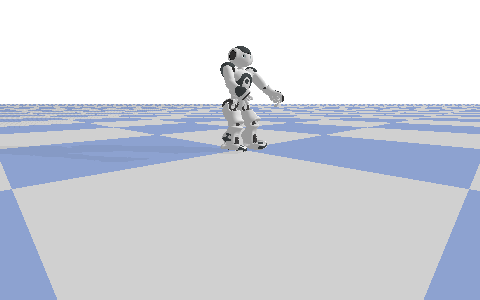

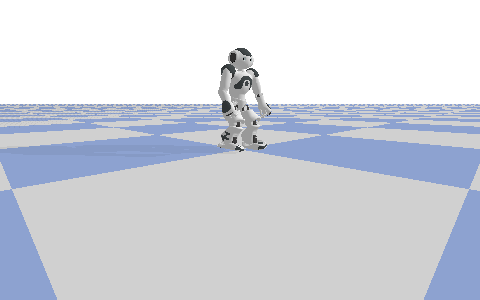

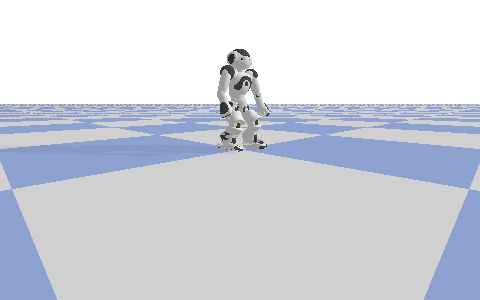

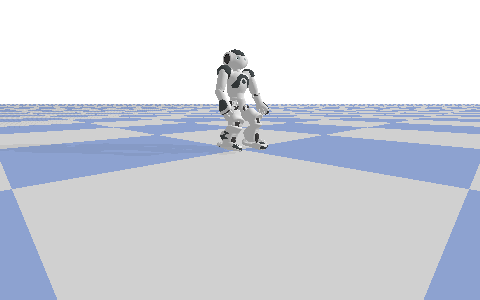

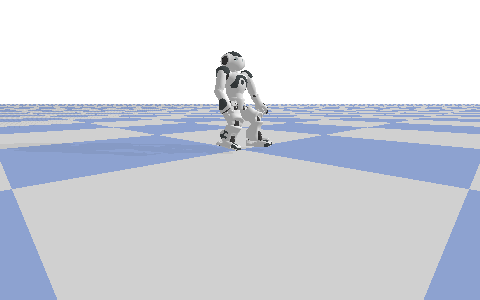

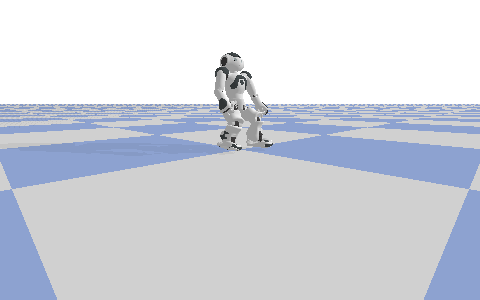

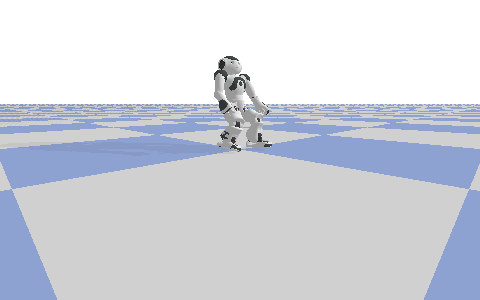

Exception in thread Thread-27:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 1,	T: 95,	G: -2.25e+03,	avg_r: -24,	avg_G: -2.25e+03,	t: 94,	dt: 450.897ms
Exception in thread Thread-39:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



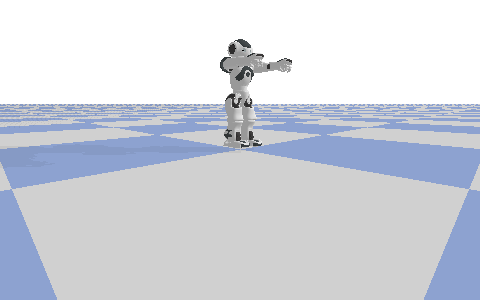

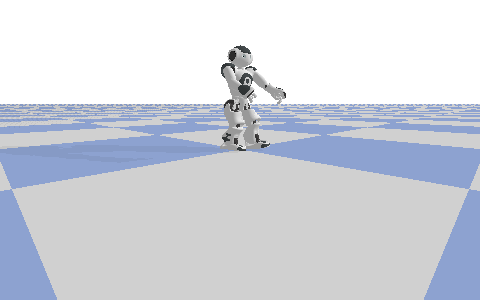

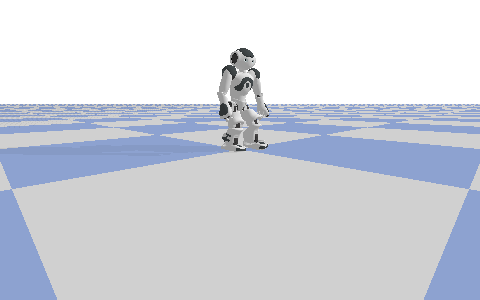

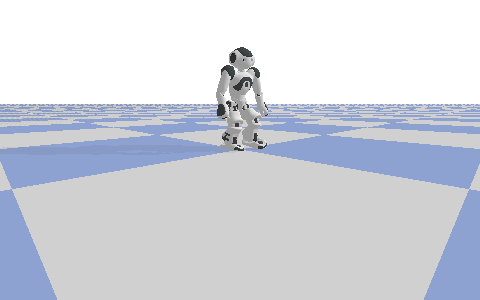

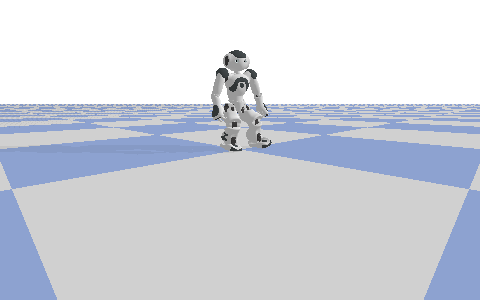

Exception in thread Thread-52:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 2,	T: 194,	G: -2.46e+03,	avg_r: -25.1,	avg_G: -2.36e+03,	t: 98,	dt: 432.902ms
Exception in thread Thread-64:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



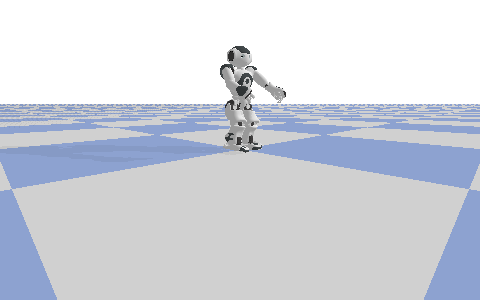

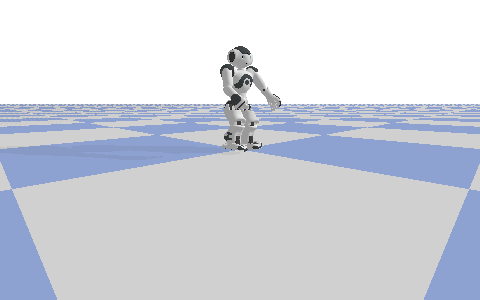

Exception in thread Thread-76:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 3,	T: 244,	G: -786,	avg_r: -16,	avg_G: -1.83e+03,	t: 49,	dt: 431.294ms
Exception in thread Thread-88:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



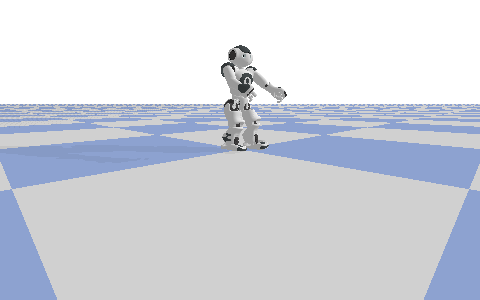

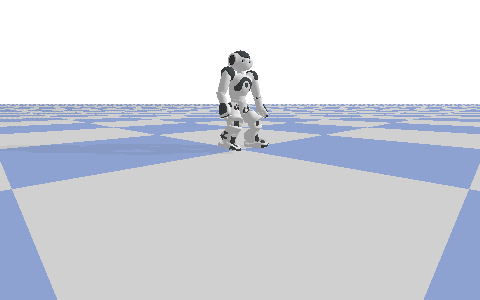

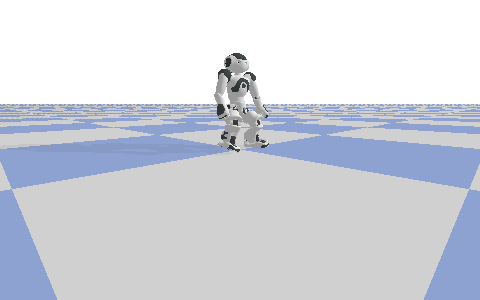

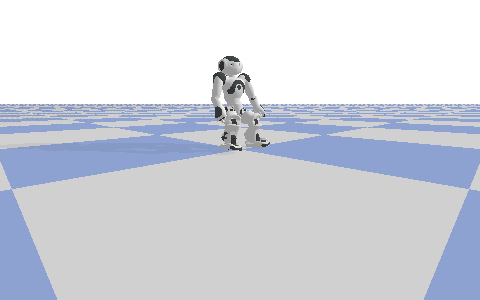

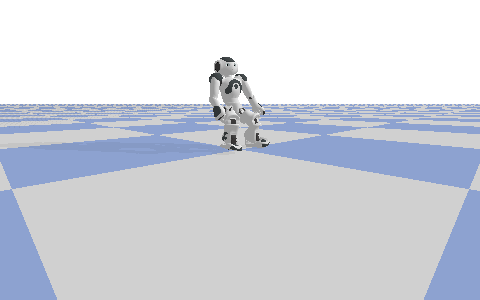

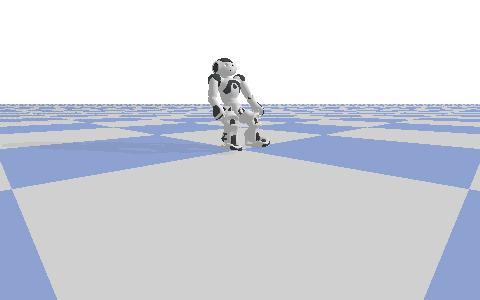

Exception in thread Thread-100:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 4,	T: 386,	G: -4.12e+03,	avg_r: -29.2,	avg_G: -2.4e+03,	t: 141,	dt: 624.787ms,	SimpleTD/loss: 87.3,	VanillaPG/loss: -17.1
Exception in thread Thread-112:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkSta

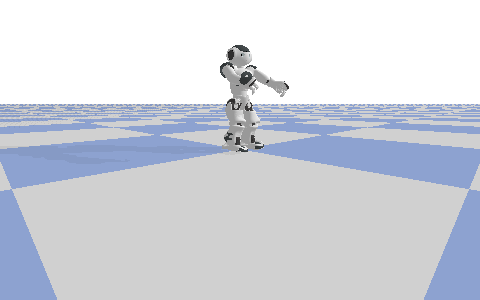

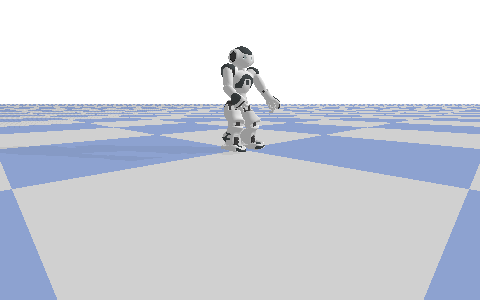

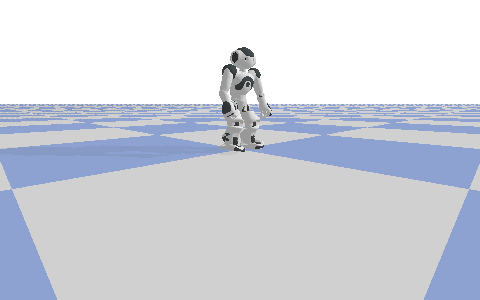

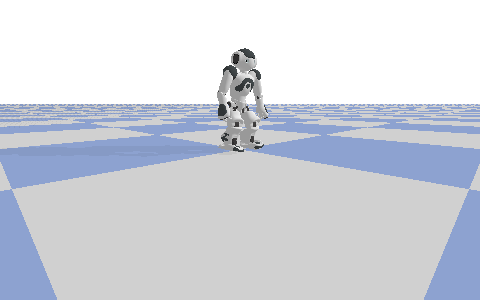

Exception in thread Thread-124:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 5,	T: 441,	G: -975,	avg_r: -18.1,	avg_G: -2.12e+03,	t: 54,	dt: 389.885ms
Exception in thread Thread-136:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



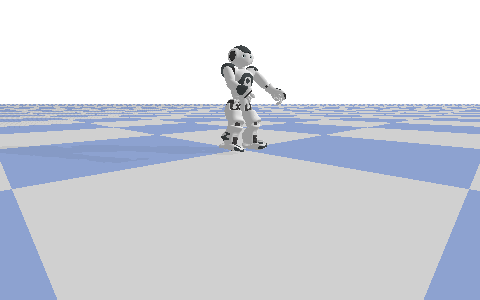

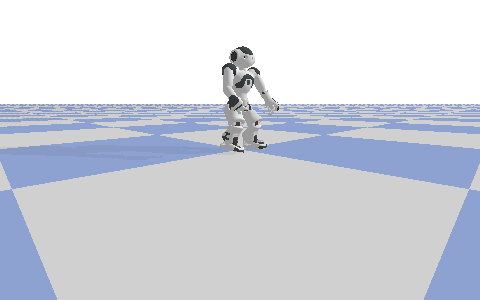

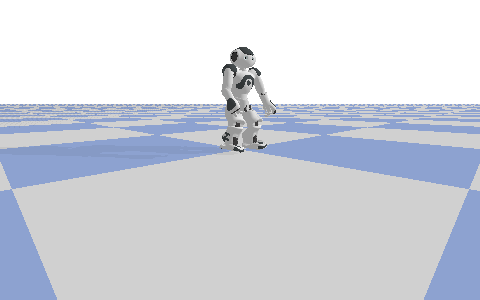

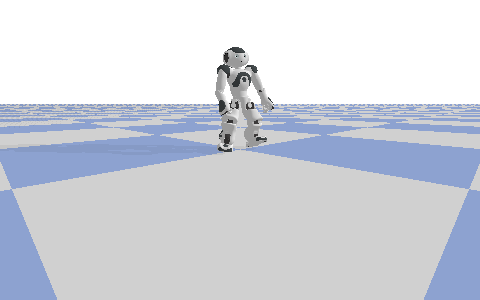

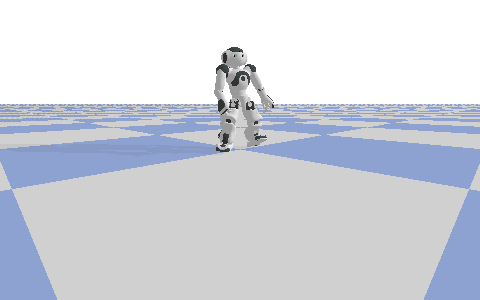

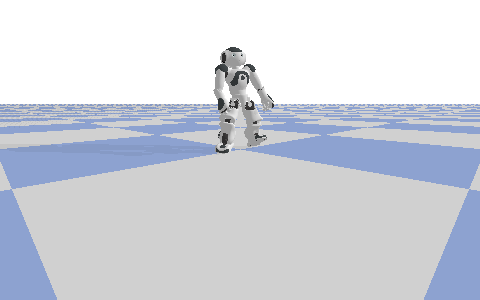

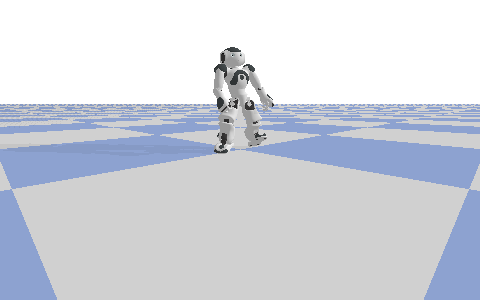

Exception in thread Thread-148:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 6,	T: 584,	G: -4.85e+03,	avg_r: -34.2,	avg_G: -2.57e+03,	t: 142,	dt: 522.800ms,	SimpleTD/loss: 91.2,	VanillaPG/loss: -21.1
Exception in thread Thread-160:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkSt

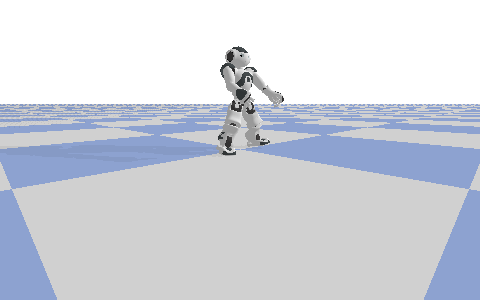

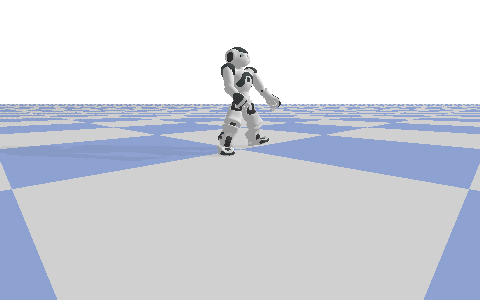

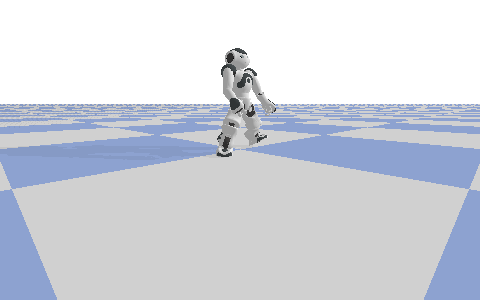

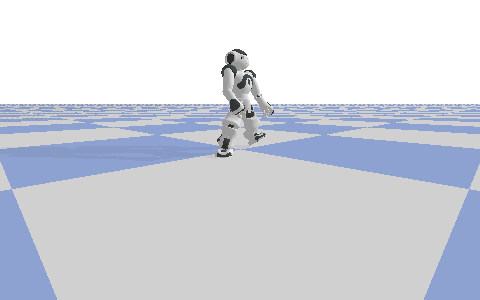

Exception in thread Thread-172:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 7,	T: 657,	G: -2.03e+03,	avg_r: -28.2,	avg_G: -2.5e+03,	t: 72,	dt: 379.232ms
Exception in thread Thread-184:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



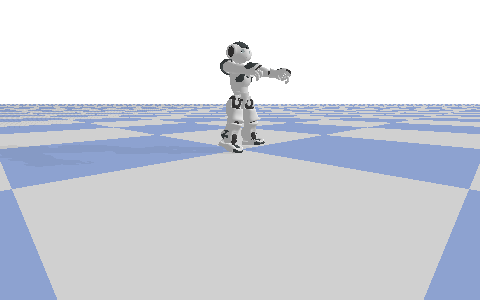

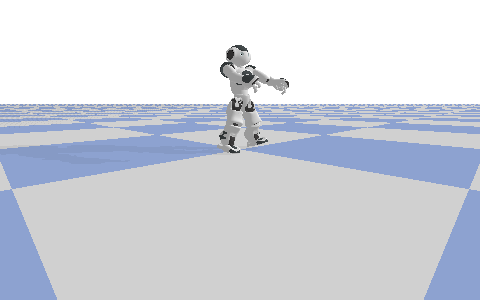

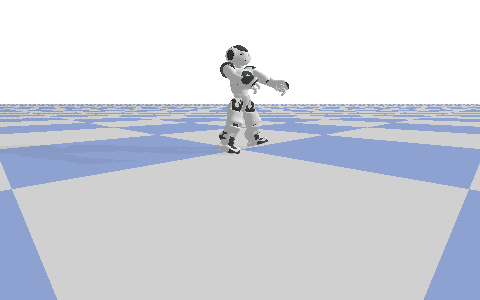

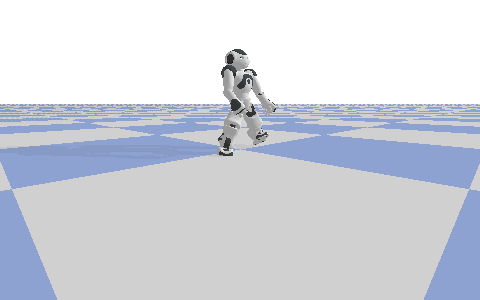

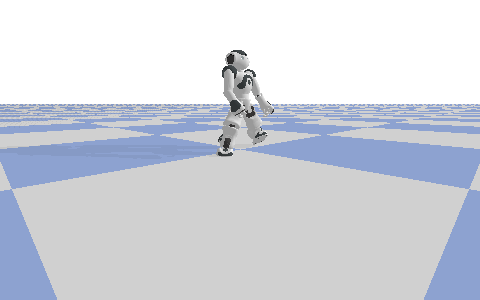

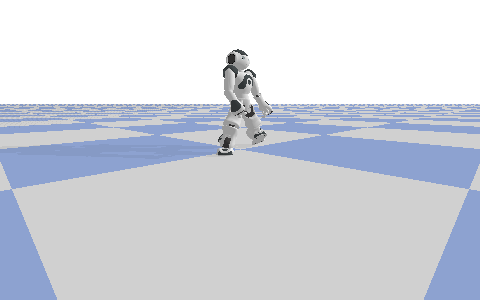

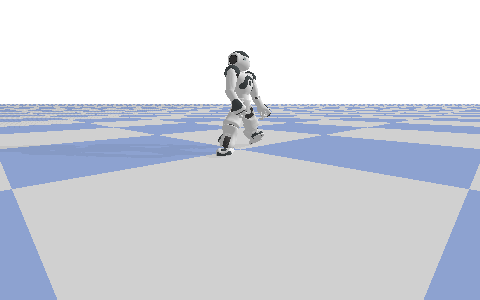

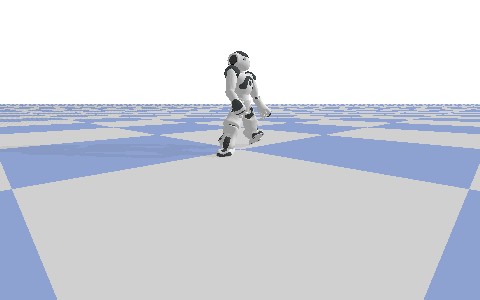

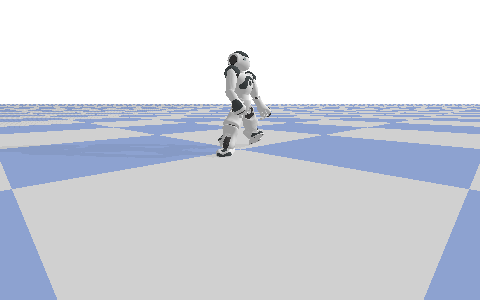

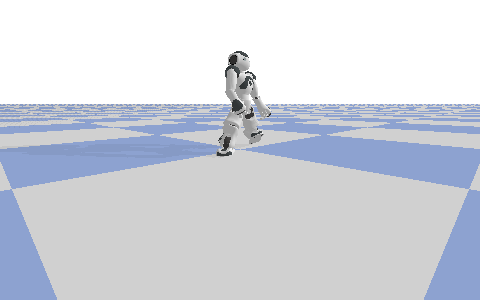

Exception in thread Thread-196:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 8,	T: 760,	G: -3.42e+03,	avg_r: -33.5,	avg_G: -2.61e+03,	t: 102,	dt: 381.731ms
Exception in thread Thread-208:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



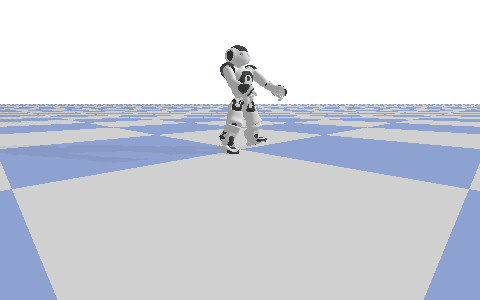

Exception in thread Thread-220:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 9,	T: 830,	G: -2.02e+03,	avg_r: -29.2,	avg_G: -2.55e+03,	t: 69,	dt: 689.020ms,	SimpleTD/loss: 45.7,	VanillaPG/loss: 8.03
Exception in thread Thread-232:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkStat

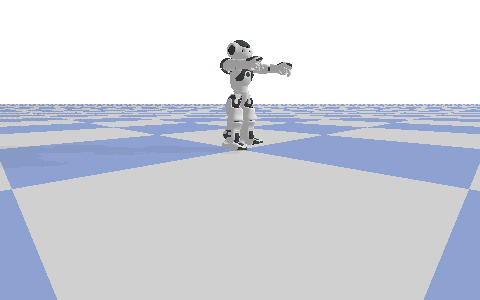

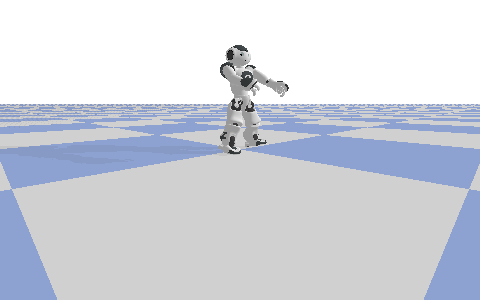

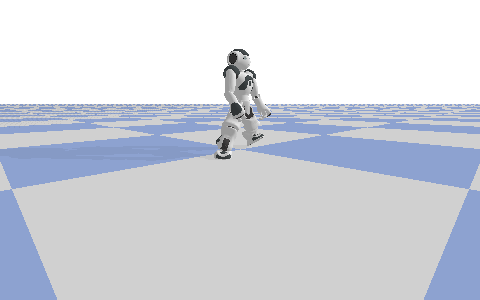

Exception in thread Thread-244:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 10,	T: 903,	G: -1.66e+03,	avg_r: -23,	avg_G: -2.46e+03,	t: 72,	dt: 386.972ms
Exception in thread Thread-256:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



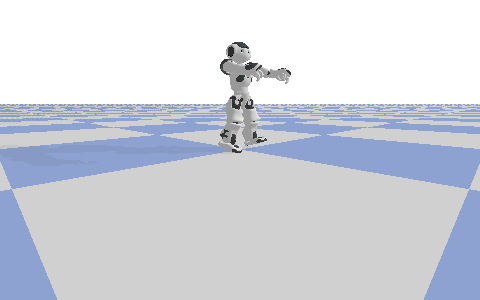

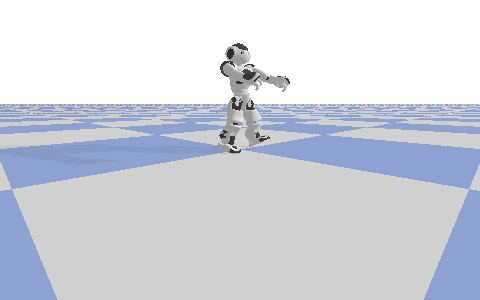

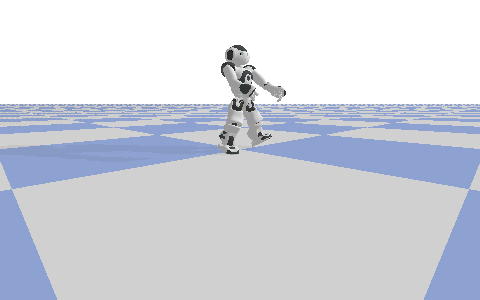

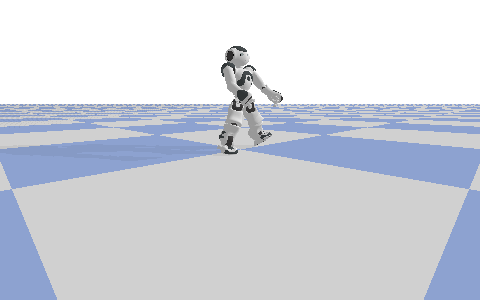

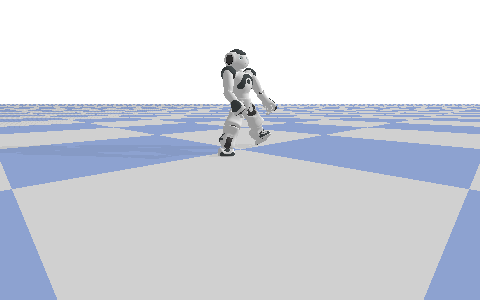

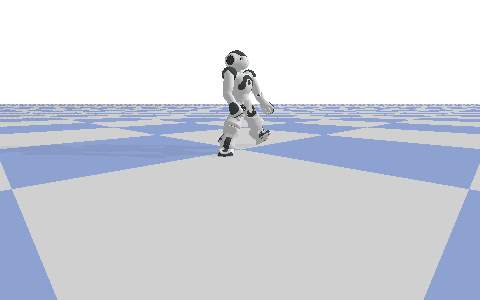

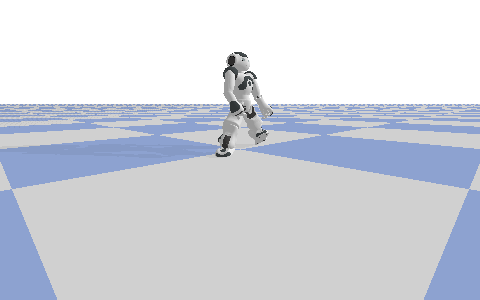

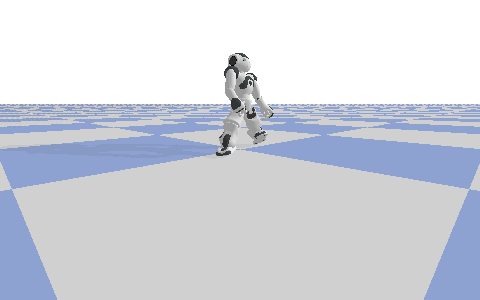

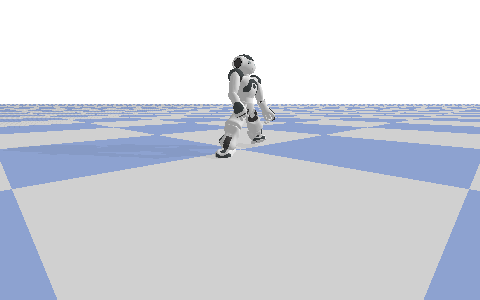

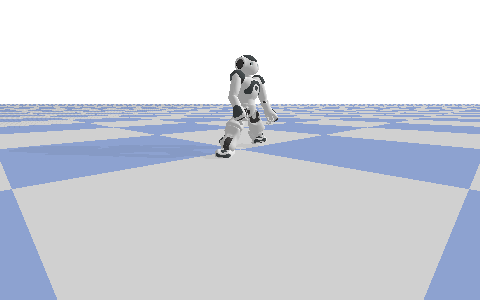

Exception in thread Thread-268:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 11,	T: 1,062,	G: -6.4e+03,	avg_r: -40.5,	avg_G: -2.85e+03,	t: 158,	dt: 514.199ms,	SimpleTD/loss: 29.8,	VanillaPG/loss: 2.14
Exception in thread Thread-280:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkS

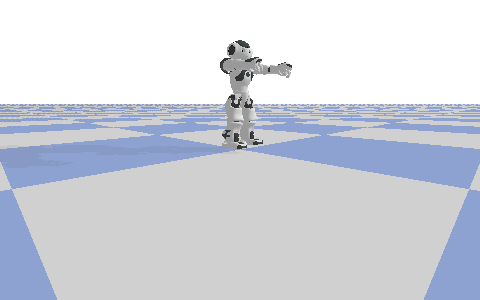

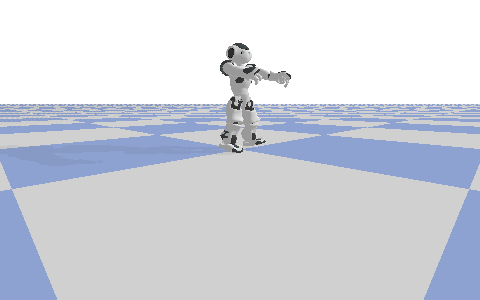

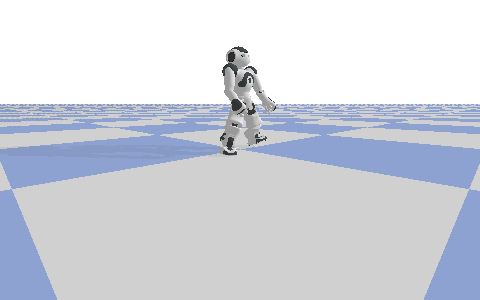

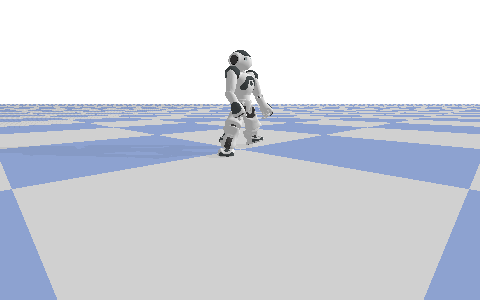

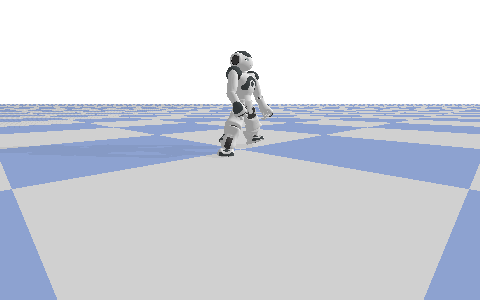

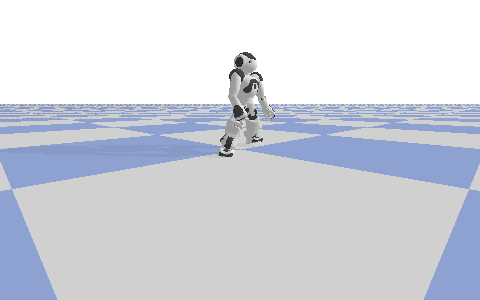

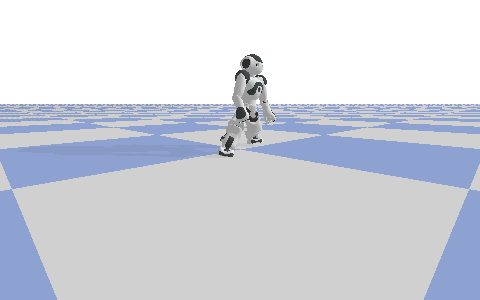

Exception in thread Thread-292:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 12,	T: 1,204,	G: -3.68e+03,	avg_r: -26.1,	avg_G: -2.93e+03,	t: 141,	dt: 382.580ms
Exception in thread Thread-304:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



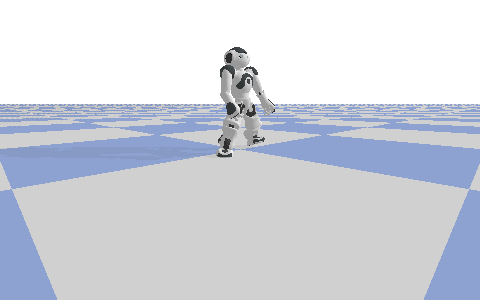

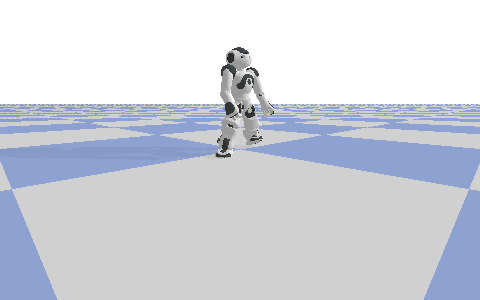

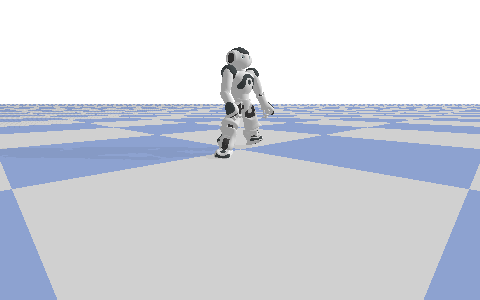

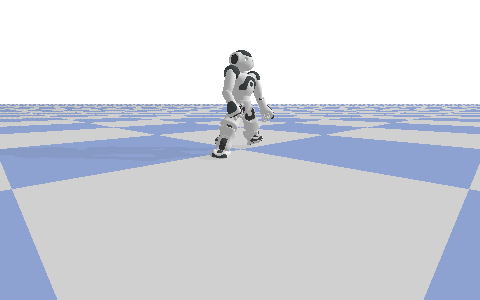

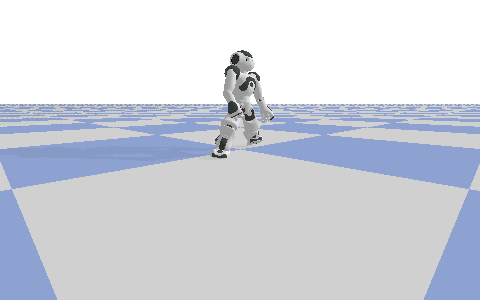

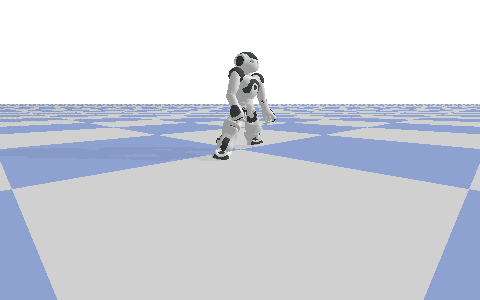

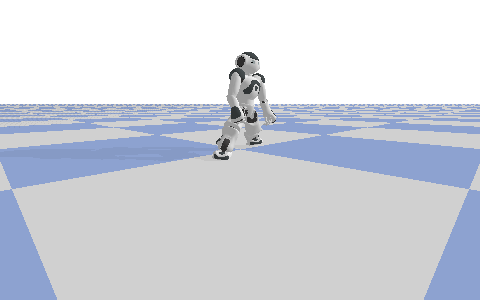

Exception in thread Thread-316:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 13,	T: 1,327,	G: -2.99e+03,	avg_r: -24.5,	avg_G: -2.94e+03,	t: 122,	dt: 561.598ms,	SimpleTD/loss: 17.4,	VanillaPG/loss: -0.185
Exception in thread Thread-328:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLi

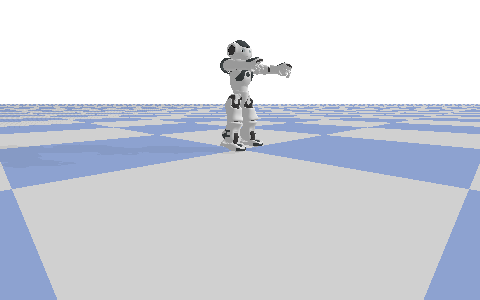

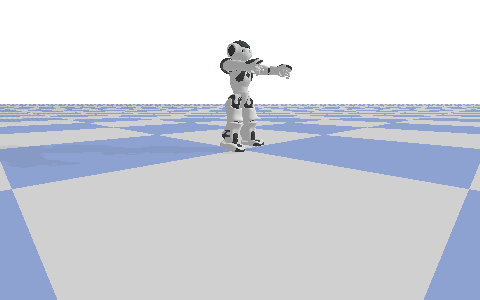

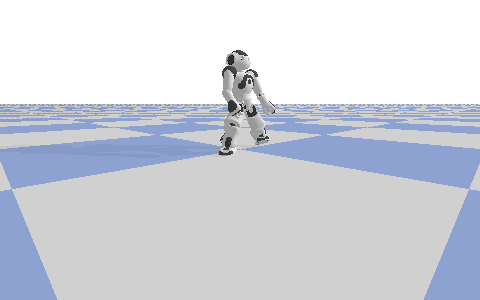

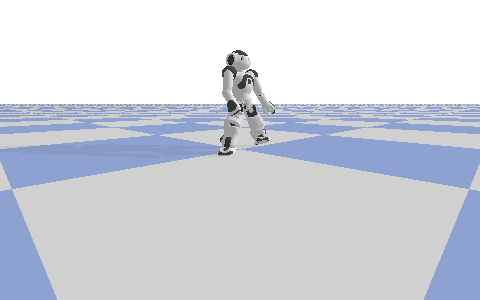

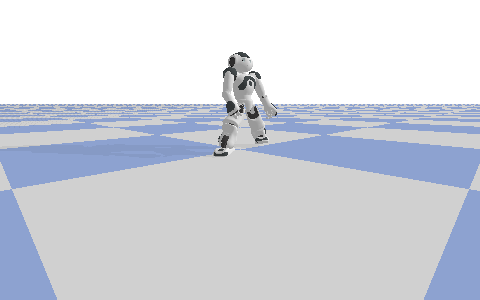

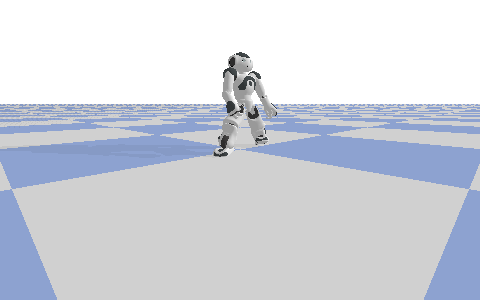

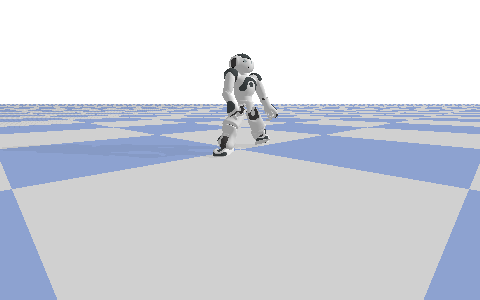

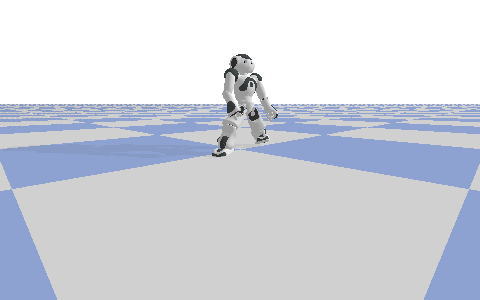

Exception in thread Thread-340:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 14,	T: 1,447,	G: -3.4e+03,	avg_r: -28.6,	avg_G: -2.99e+03,	t: 119,	dt: 377.497ms
Exception in thread Thread-352:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



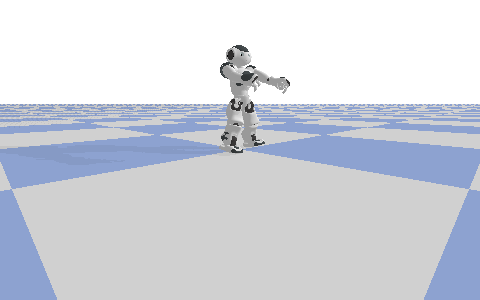

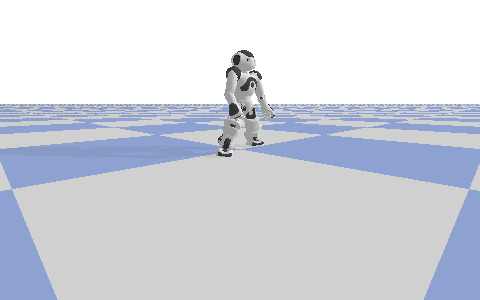

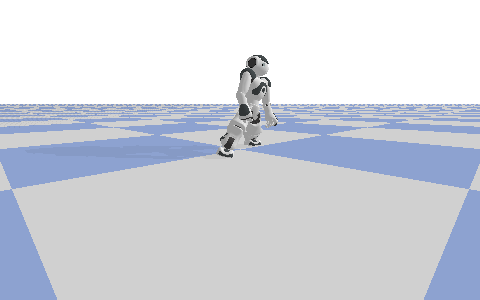

Exception in thread Thread-364:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 15,	T: 1,556,	G: -2.21e+03,	avg_r: -20.5,	avg_G: -2.91e+03,	t: 108,	dt: 572.870ms,	SimpleTD/loss: 24.4,	VanillaPG/loss: 1.16
Exception in thread Thread-376:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLink

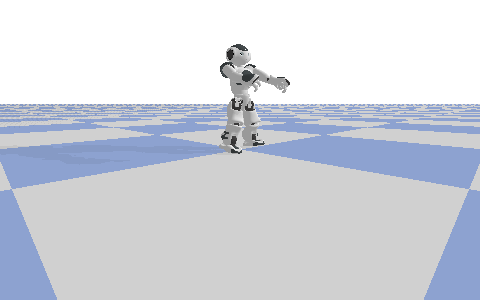

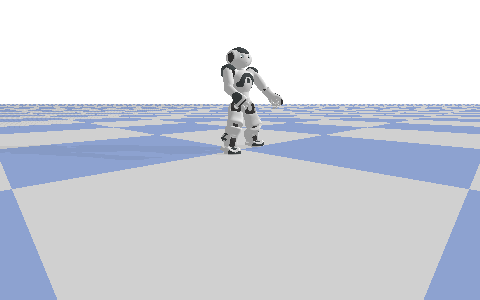

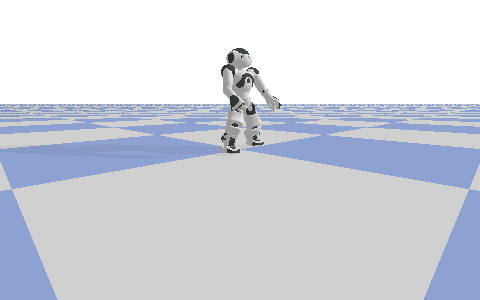

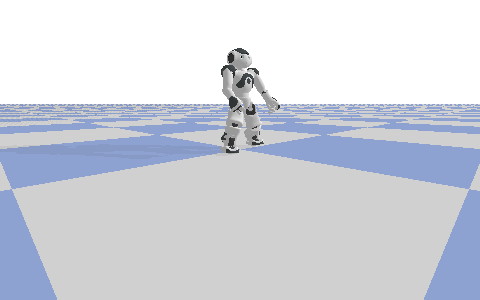

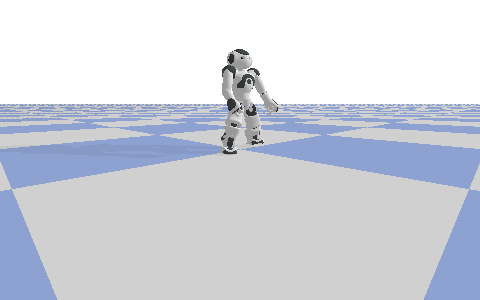

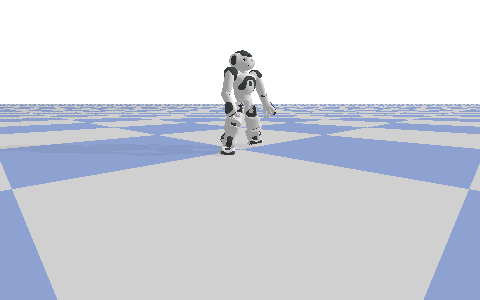

Exception in thread Thread-388:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 16,	T: 1,647,	G: -1.67e+03,	avg_r: -18.6,	avg_G: -2.79e+03,	t: 90,	dt: 381.015ms
Exception in thread Thread-400:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



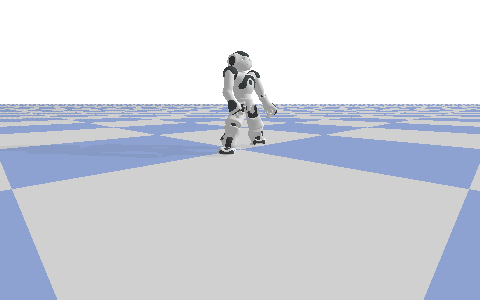

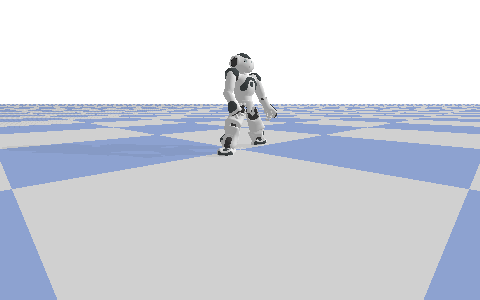

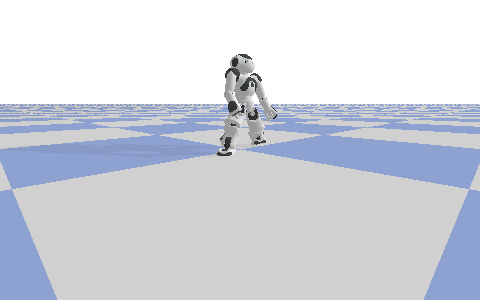

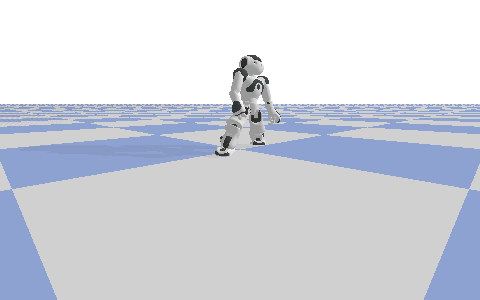

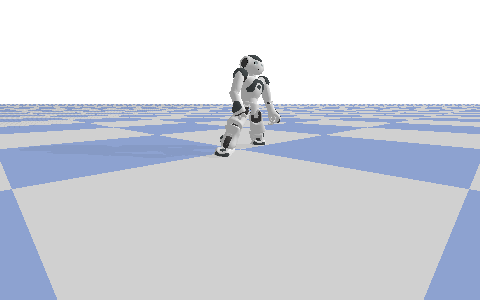

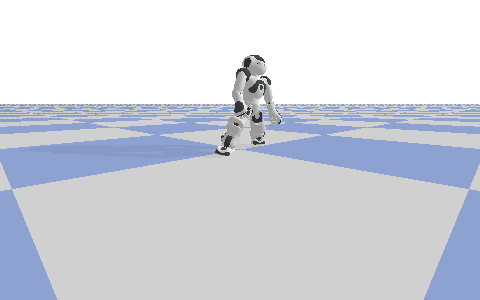

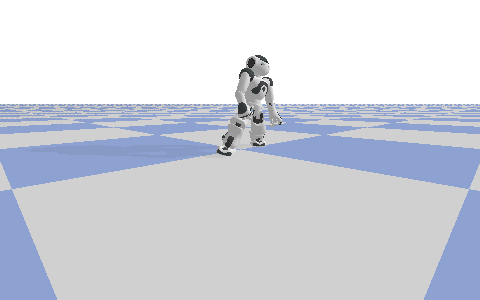

Exception in thread Thread-412:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 17,	T: 1,795,	G: -3.47e+03,	avg_r: -23.6,	avg_G: -2.85e+03,	t: 147,	dt: 380.289ms
Exception in thread Thread-424:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



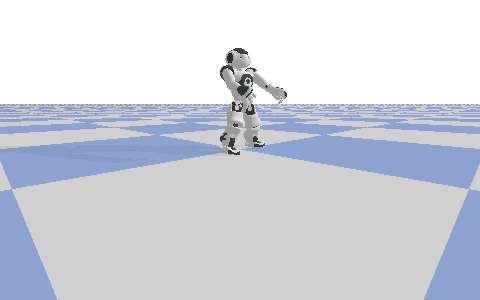

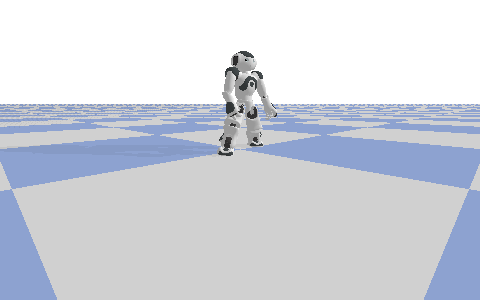

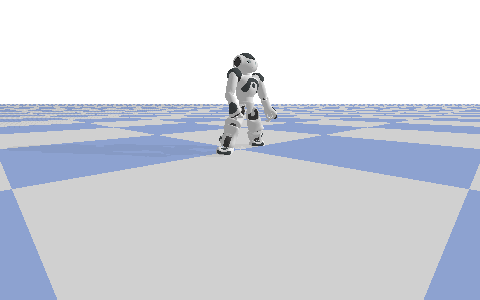

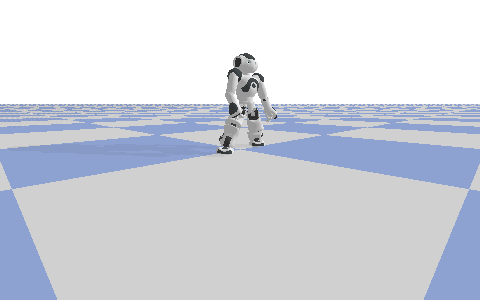

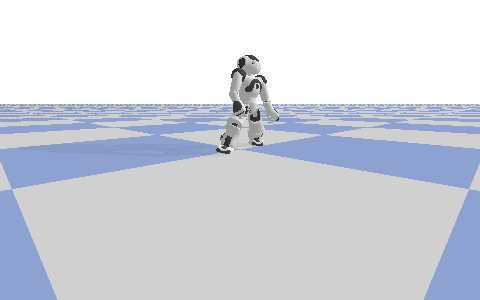

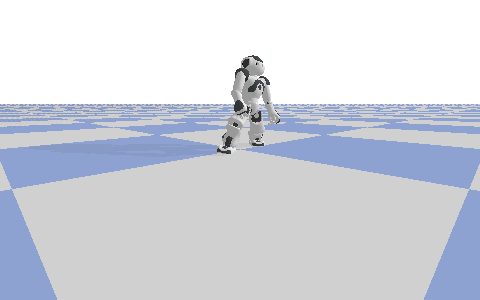

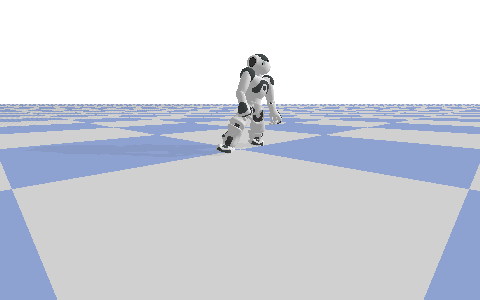

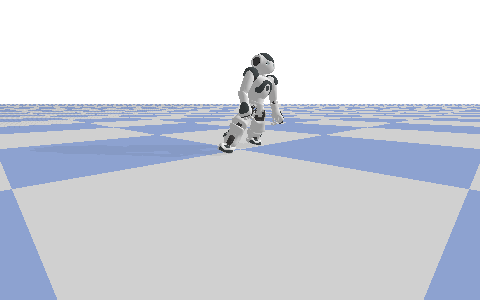

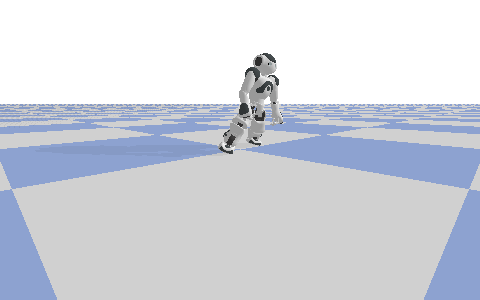

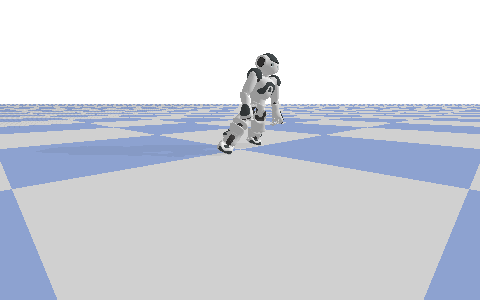

Exception in thread Thread-436:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 18,	T: 1,945,	G: -3.8e+03,	avg_r: -25.5,	avg_G: -2.95e+03,	t: 149,	dt: 522.016ms,	SimpleTD/loss: 16.9,	VanillaPG/loss: 0.0846
Exception in thread Thread-448:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLin

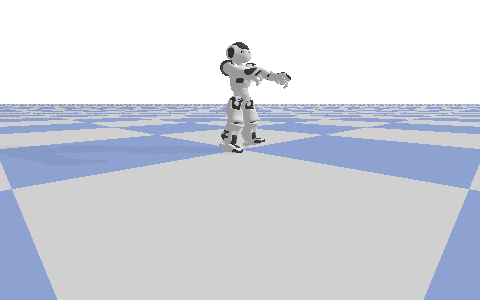

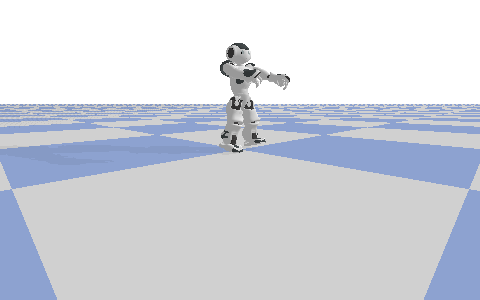

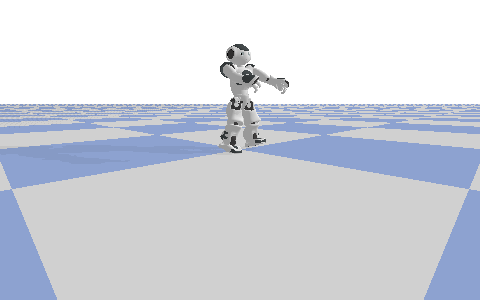

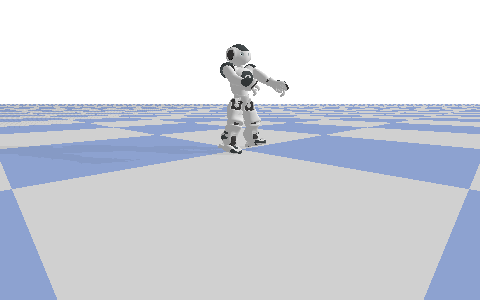

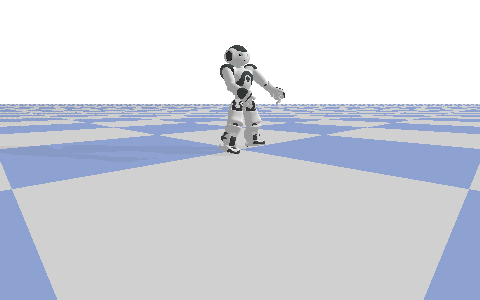

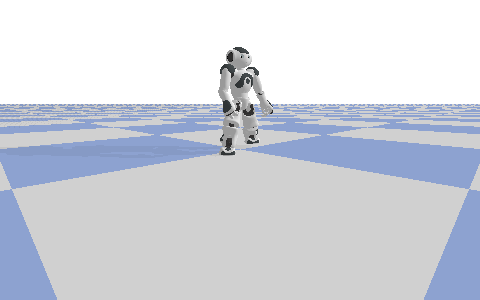

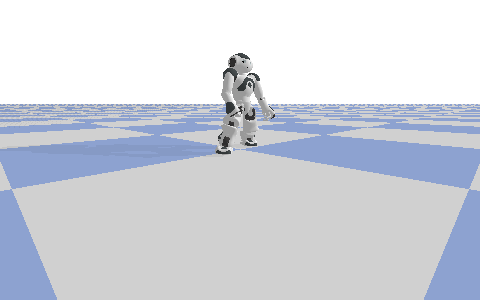

Exception in thread Thread-460:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 19,	T: 2,071,	G: -2.5e+03,	avg_r: -20,	avg_G: -2.9e+03,	t: 125,	dt: 381.918ms
Exception in thread Thread-472:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



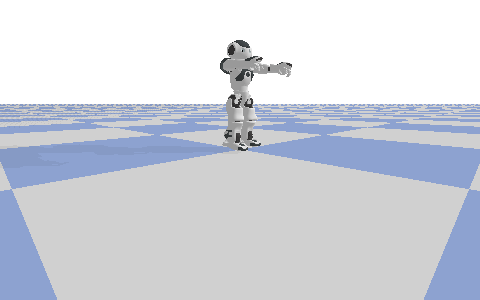

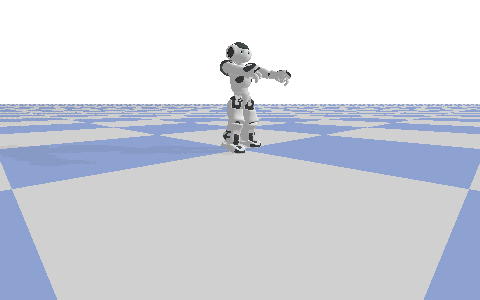

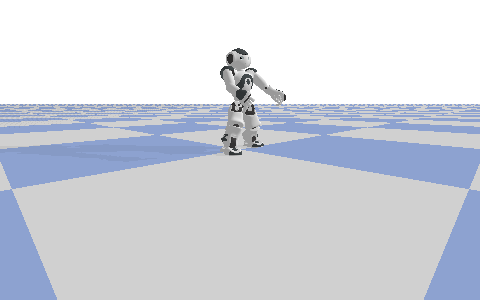

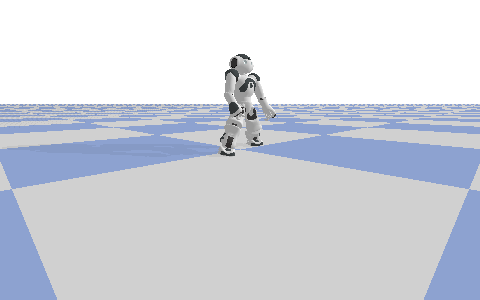

Exception in thread Thread-484:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 20,	T: 2,159,	G: -1.76e+03,	avg_r: -20.3,	avg_G: -2.79e+03,	t: 87,	dt: 617.899ms,	SimpleTD/loss: 25.2,	VanillaPG/loss: -0.688
Exception in thread Thread-496:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLin

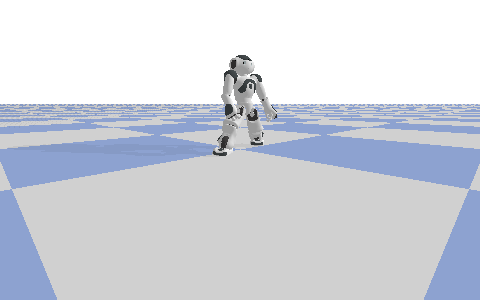

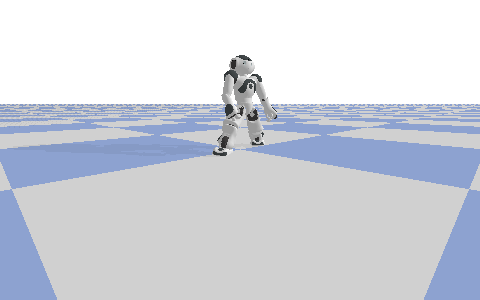

Exception in thread Thread-508:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 21,	T: 2,253,	G: -1.91e+03,	avg_r: -20.5,	avg_G: -2.7e+03,	t: 93,	dt: 379.535ms
Exception in thread Thread-520:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



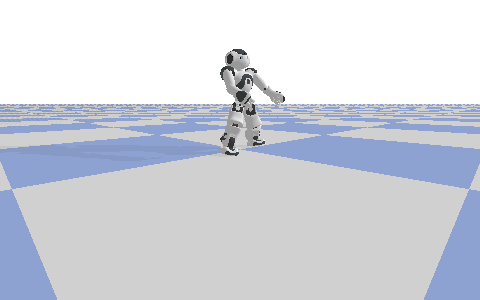

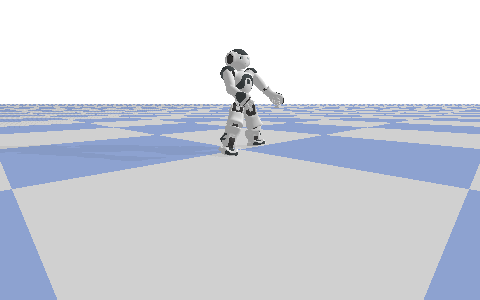

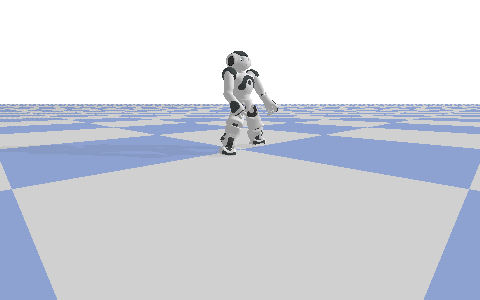

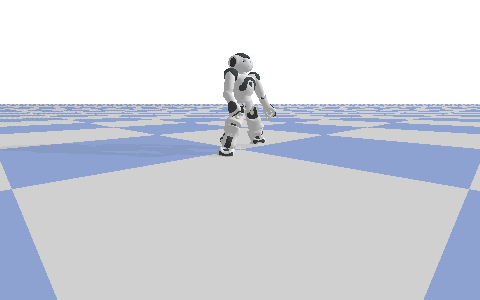

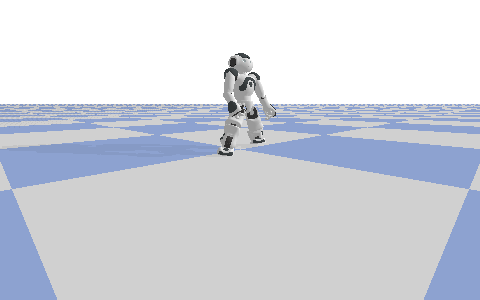

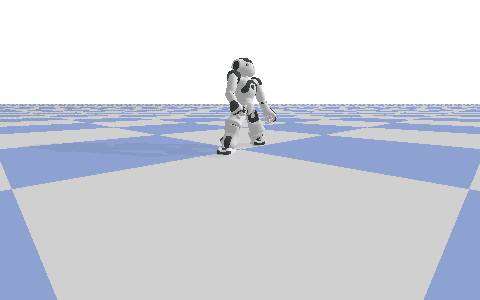

Exception in thread Thread-532:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 22,	T: 2,343,	G: -1.98e+03,	avg_r: -22.3,	avg_G: -2.63e+03,	t: 89,	dt: 621.996ms,	SimpleTD/loss: 14.6,	VanillaPG/loss: -0.39
Exception in thread Thread-544:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLink

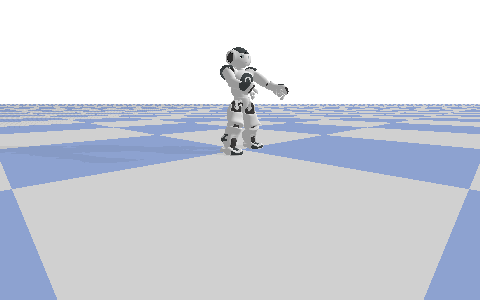

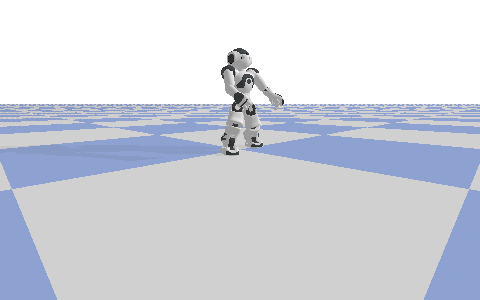

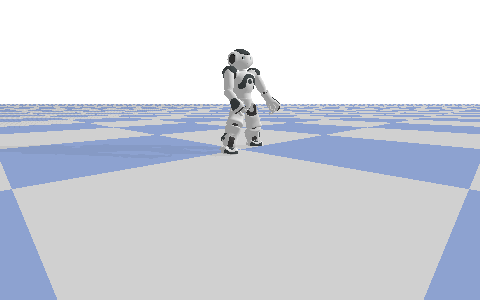

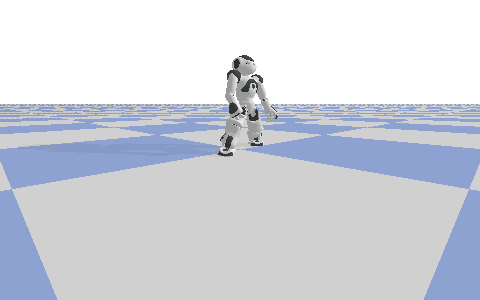

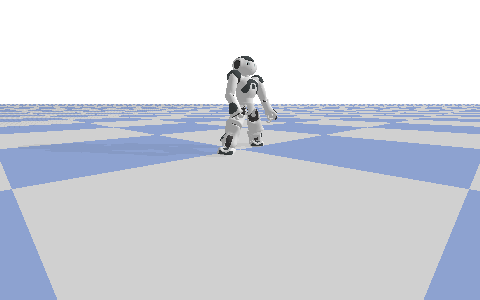

Exception in thread Thread-556:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 23,	T: 2,438,	G: -1.61e+03,	avg_r: -17.2,	avg_G: -2.53e+03,	t: 94,	dt: 373.579ms
Exception in thread Thread-568:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



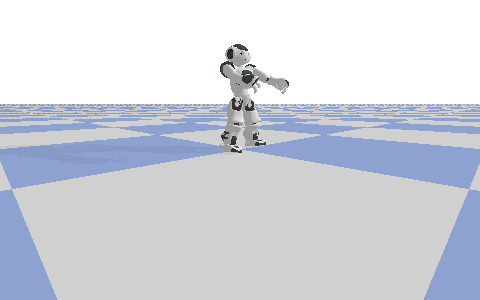

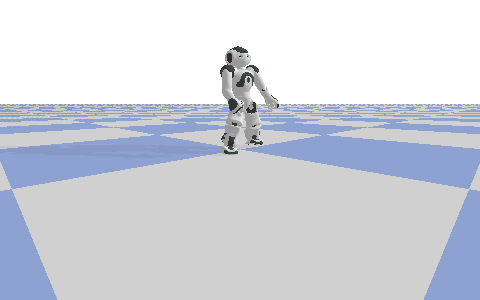

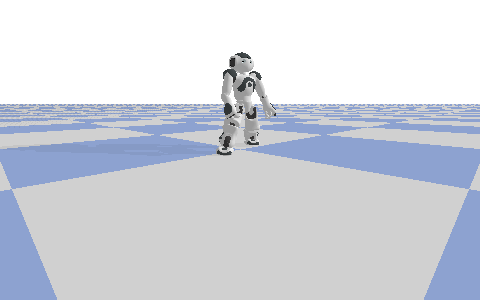

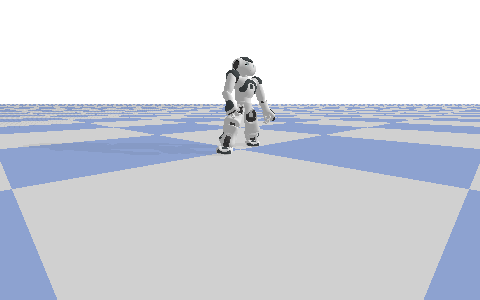

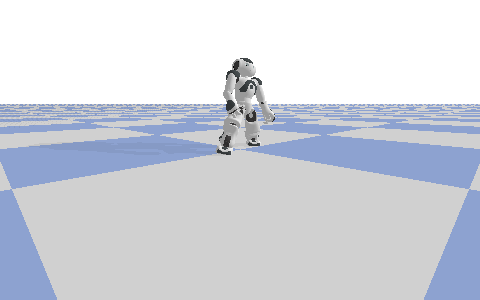

Exception in thread Thread-580:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 24,	T: 2,546,	G: -2.24e+03,	avg_r: -21,	avg_G: -2.5e+03,	t: 107,	dt: 383.449ms
Exception in thread Thread-592:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



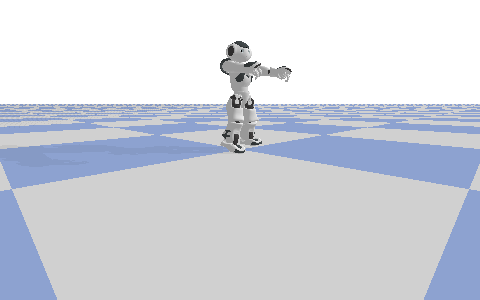

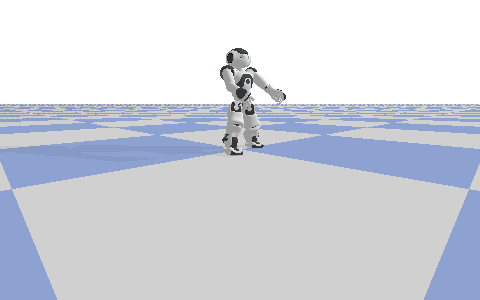

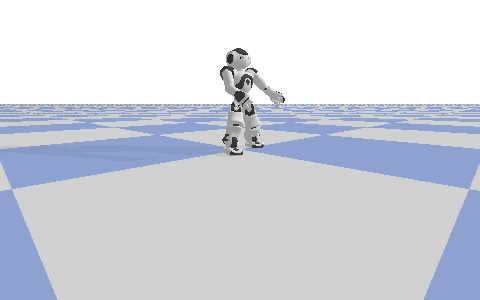

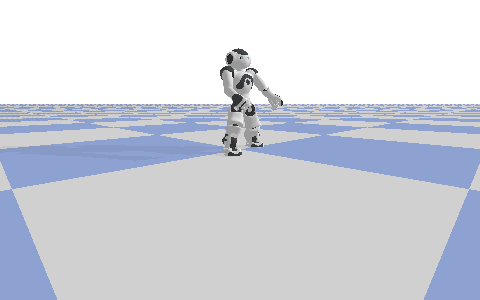

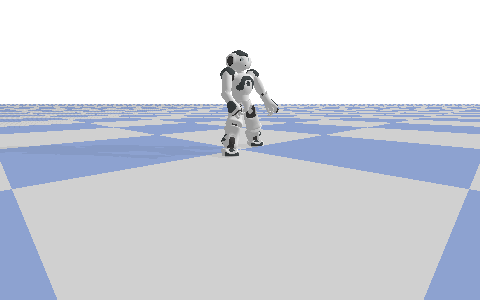

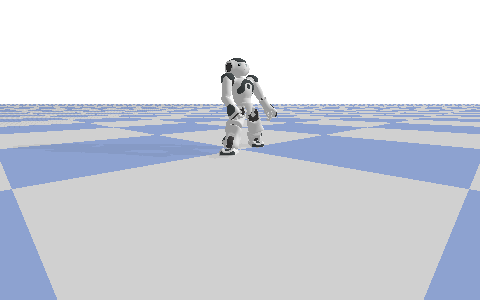

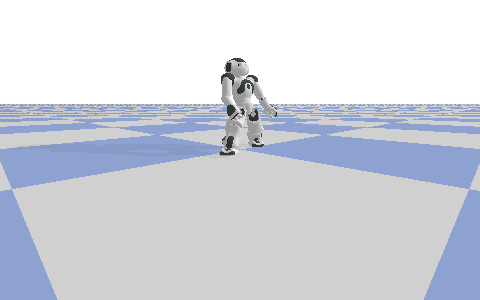

Exception in thread Thread-604:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 25,	T: 2,646,	G: -2.02e+03,	avg_r: -20.5,	avg_G: -2.45e+03,	t: 99,	dt: 583.288ms,	SimpleTD/loss: 21.1,	VanillaPG/loss: 0.24


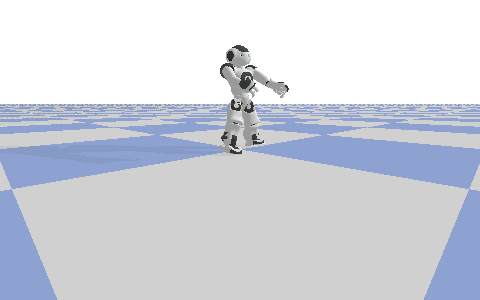

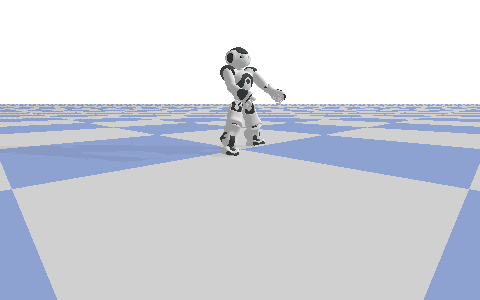

Exception in thread Thread-628:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

Exception in thread Thread-616:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 26,	T: 2,730,	G: -1.52e+03,	avg_r: -18.3,	avg_G: -2.36e+03,	t: 83,	dt: 858.823ms
Exception in thread Thread-64

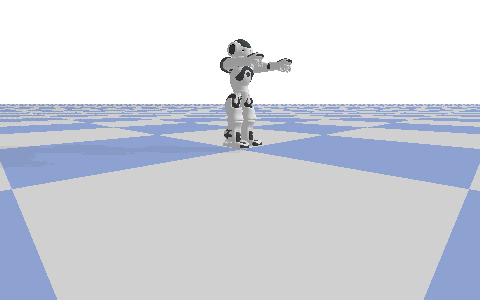

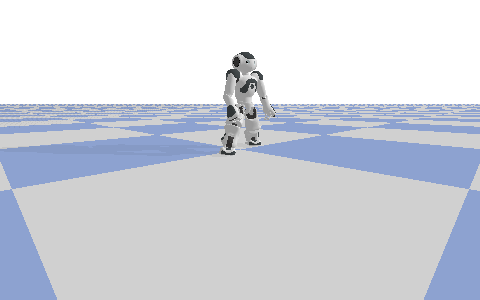

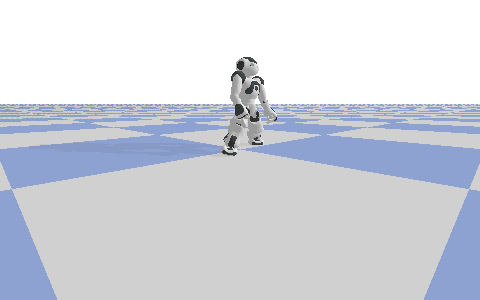

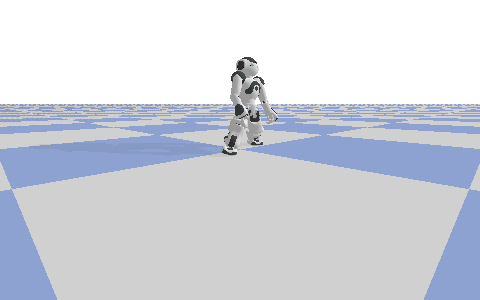

Exception in thread Thread-652:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 27,	T: 2,829,	G: -1.72e+03,	avg_r: -17.6,	avg_G: -2.3e+03,	t: 98,	dt: 377.309ms
Exception in thread Thread-664:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



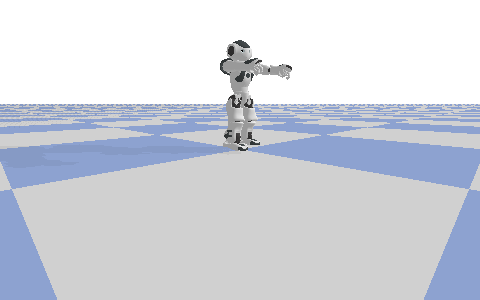

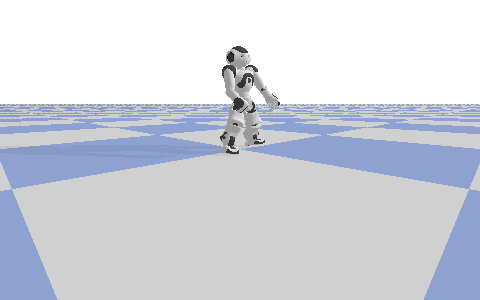

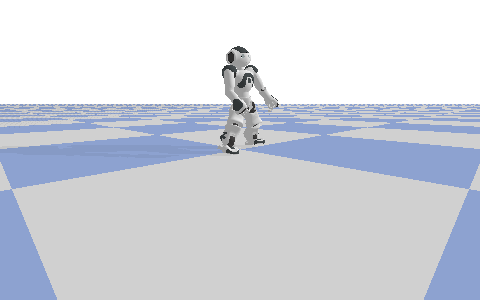

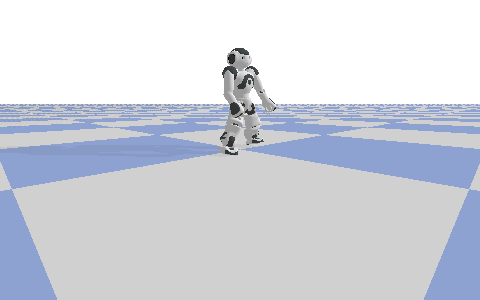

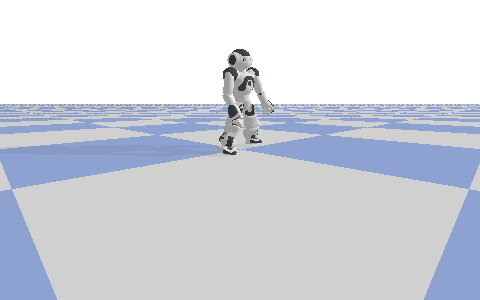

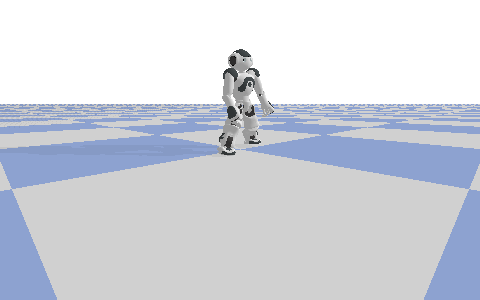

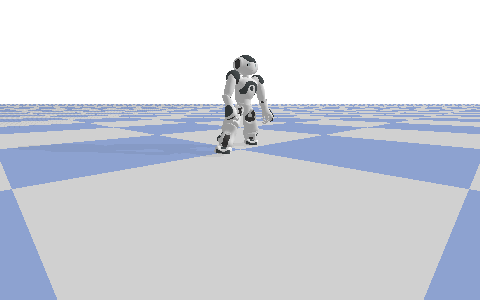

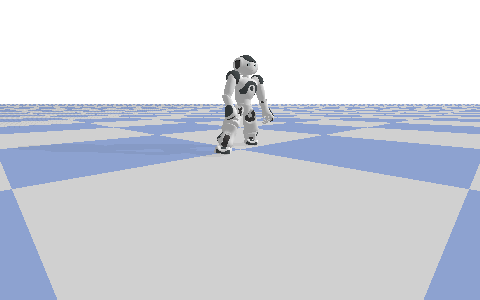

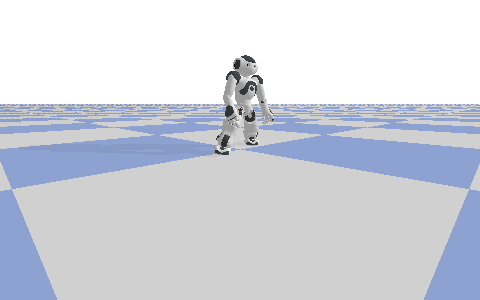

Exception in thread Thread-676:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 28,	T: 2,933,	G: -2.04e+03,	avg_r: -19.8,	avg_G: -2.27e+03,	t: 103,	dt: 588.104ms,	SimpleTD/loss: 19,	VanillaPG/loss: -0.264
Exception in thread Thread-688:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLink

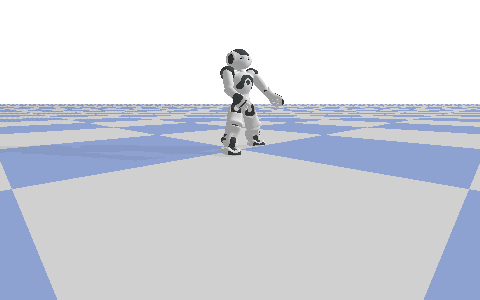

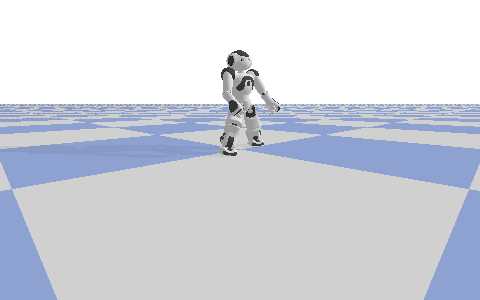

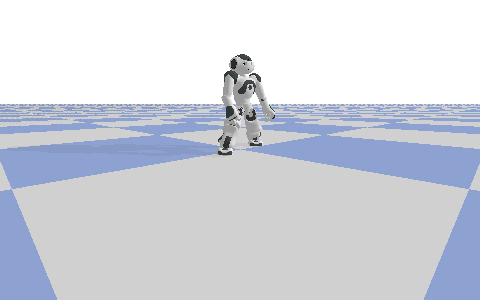

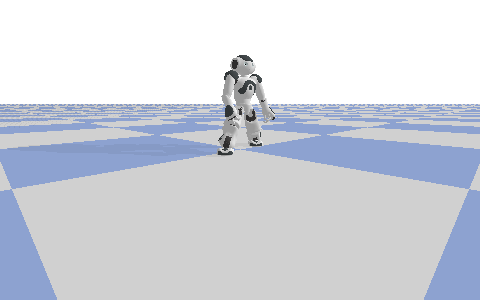

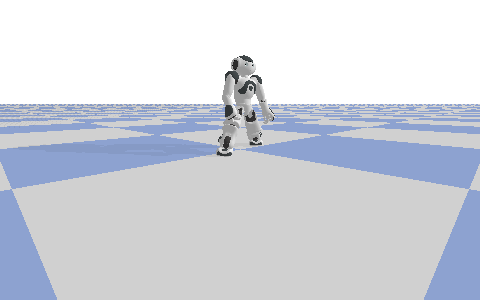

Exception in thread Thread-700:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 29,	T: 3,007,	G: -1.27e+03,	avg_r: -17.5,	avg_G: -2.17e+03,	t: 73,	dt: 379.656ms
Exception in thread Thread-712:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



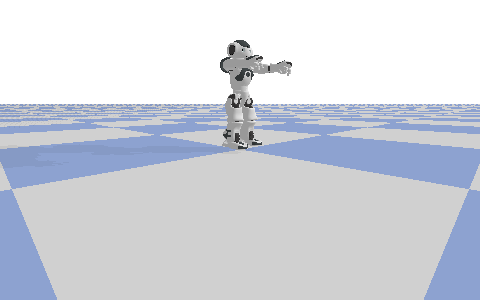

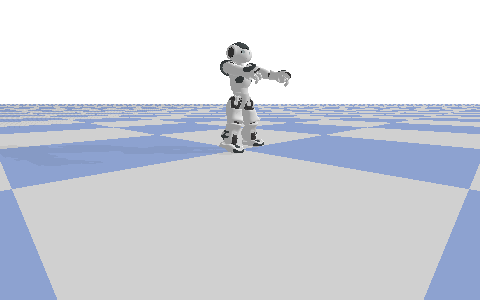

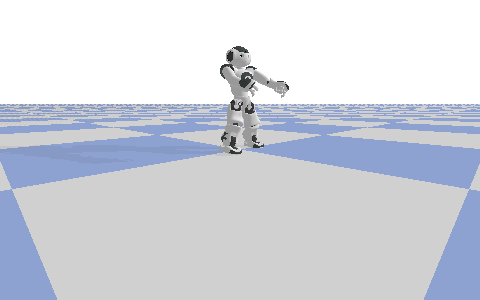

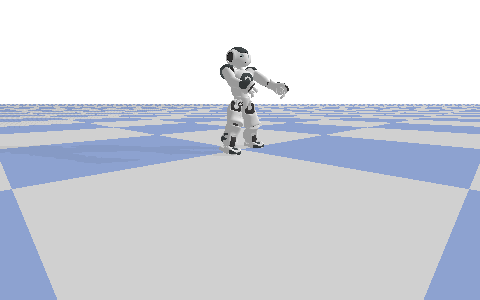

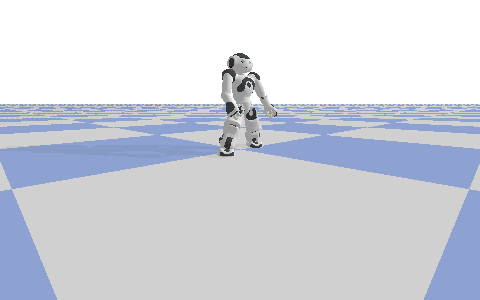

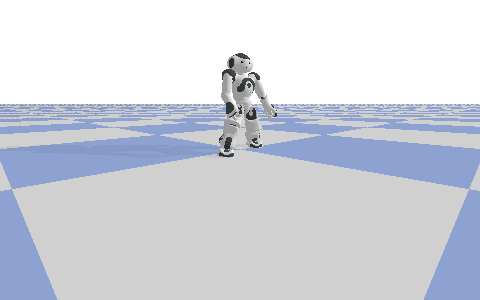

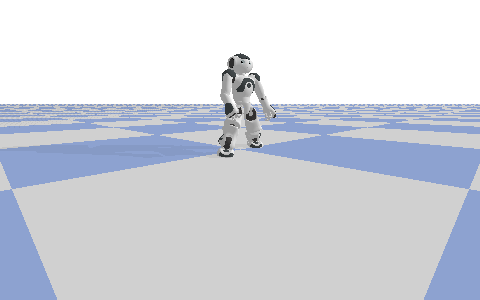

Exception in thread Thread-724:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 30,	T: 3,067,	G: -890,	avg_r: -15.1,	avg_G: -2.04e+03,	t: 59,	dt: 366.932ms
Exception in thread Thread-736:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



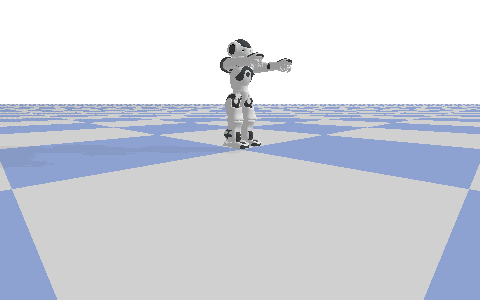

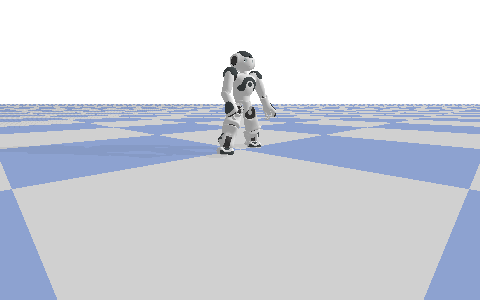

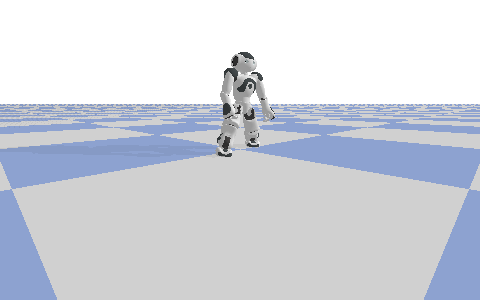

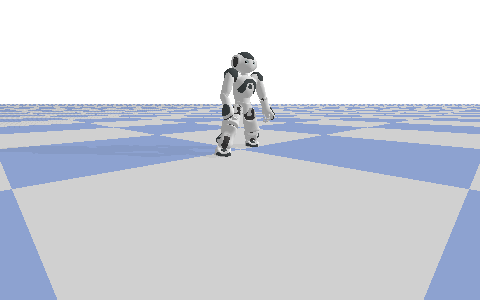

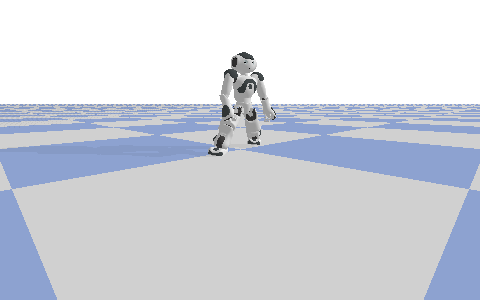

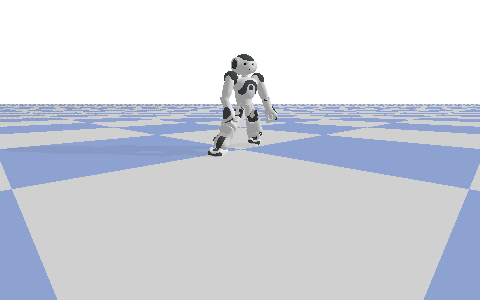

Exception in thread Thread-748:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 31,	T: 3,181,	G: -2.65e+03,	avg_r: -23.5,	avg_G: -2.1e+03,	t: 113,	dt: 564.485ms,	SimpleTD/loss: 21.6,	VanillaPG/loss: -0.0551
Exception in thread Thread-760:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLi

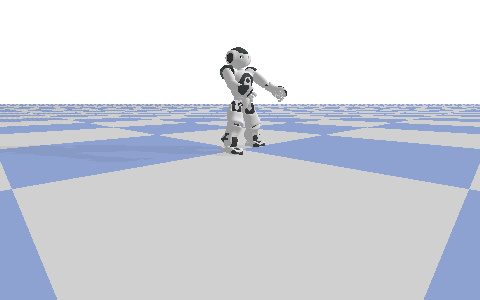

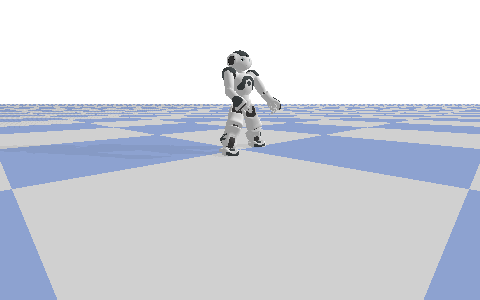

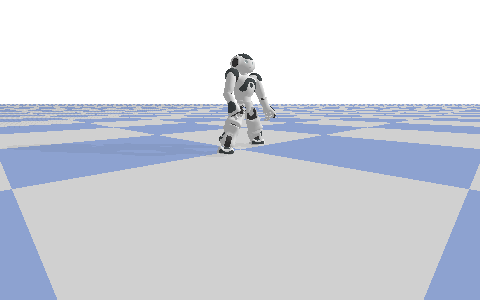

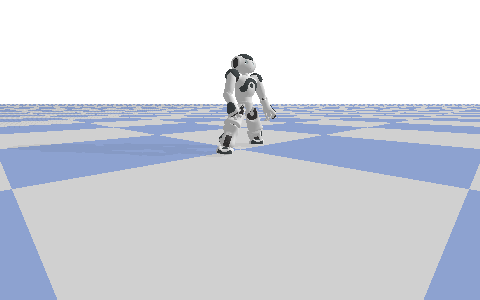

Exception in thread Thread-772:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 32,	T: 3,261,	G: -1.42e+03,	avg_r: -17.9,	avg_G: -2.03e+03,	t: 79,	dt: 377.111ms
Exception in thread Thread-784:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



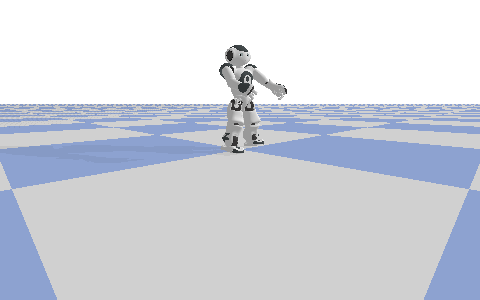

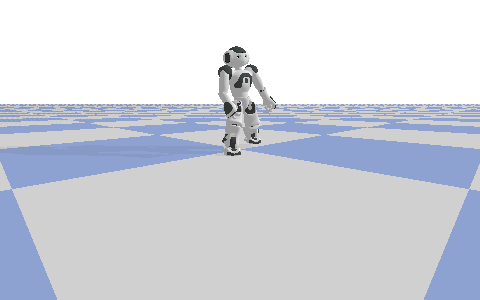

Exception in thread Thread-796:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 33,	T: 3,345,	G: -1.33e+03,	avg_r: -16.1,	avg_G: -1.96e+03,	t: 83,	dt: 378.240ms
Exception in thread Thread-808:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



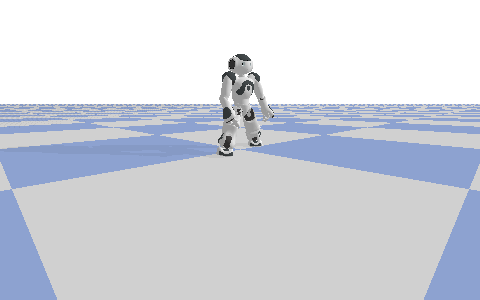

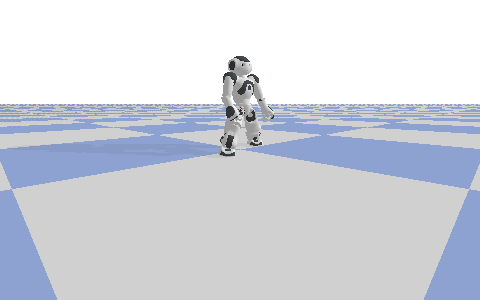

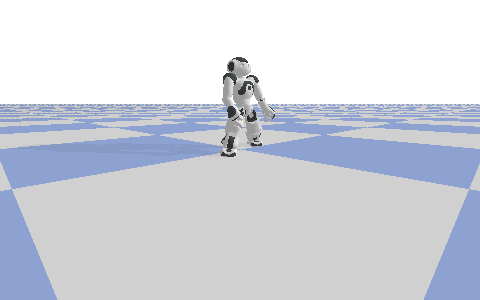

[A2C|TrainMonitor|INFO] ep: 34,	T: 3,427,	G: -1.44e+03,	avg_r: -17.8,	avg_G: -1.91e+03,	t: 81,	dt: 641.502ms,	SimpleTD/loss: 19.8,	VanillaPG/loss: 0.34
Exception in thread Thread-832:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

Exception in thread Thread-820:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkS

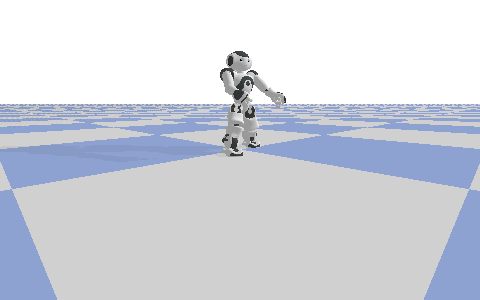

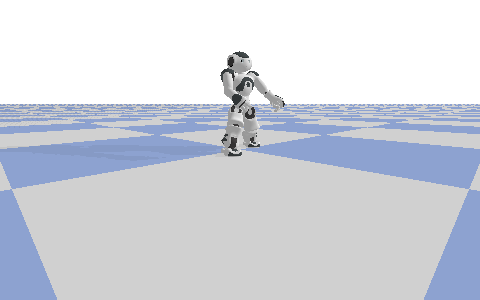

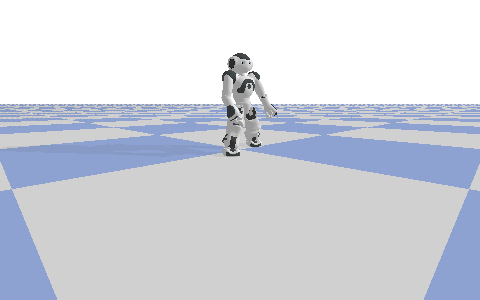

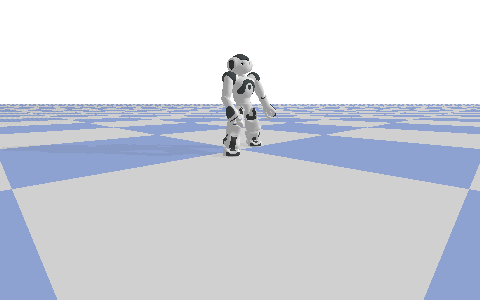

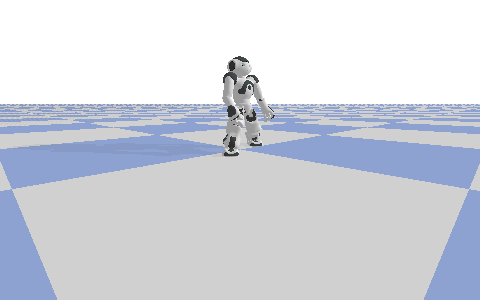

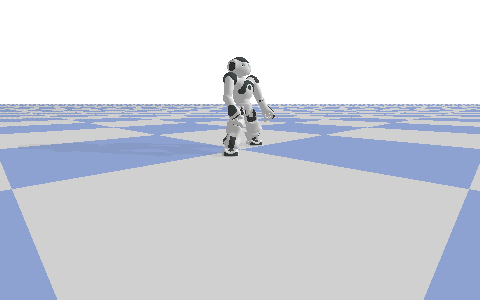

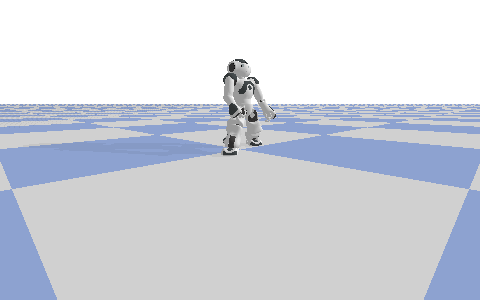

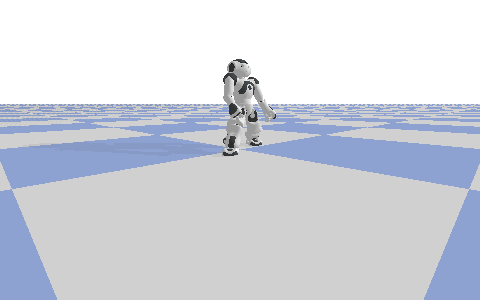

Exception in thread Thread-844:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 35,	T: 3,513,	G: -1.41e+03,	avg_r: -16.6,	avg_G: -1.86e+03,	t: 85,	dt: 368.487ms
Exception in thread Thread-856:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



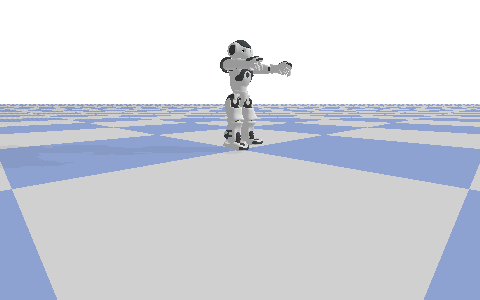

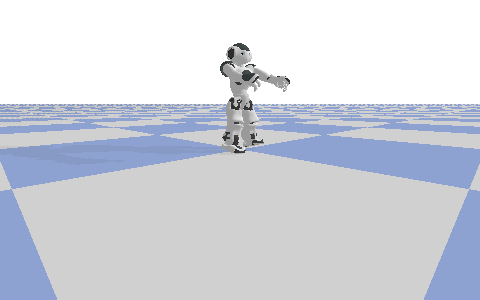

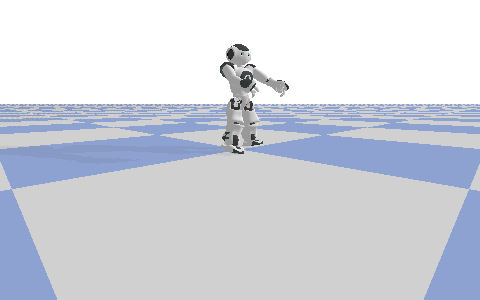

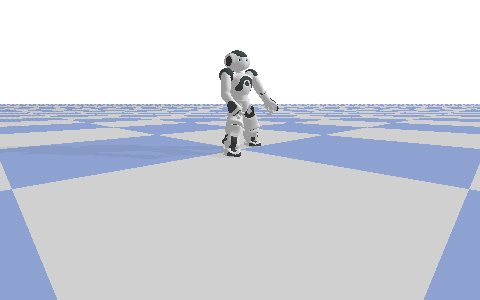

Exception in thread Thread-868:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 36,	T: 3,568,	G: -748,	avg_r: -13.9,	avg_G: -1.75e+03,	t: 54,	dt: 389.544ms
Exception in thread Thread-880:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



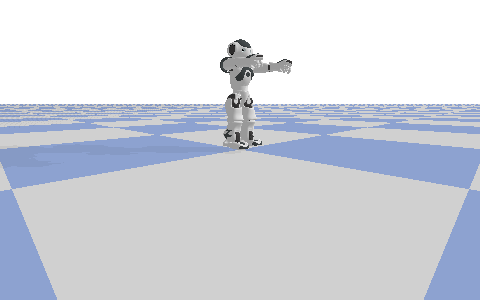

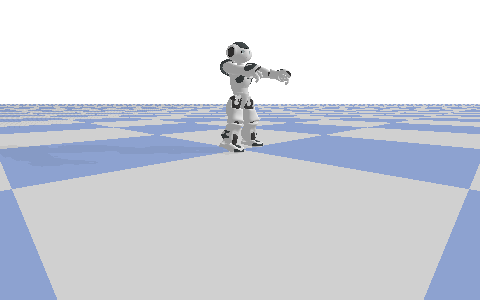

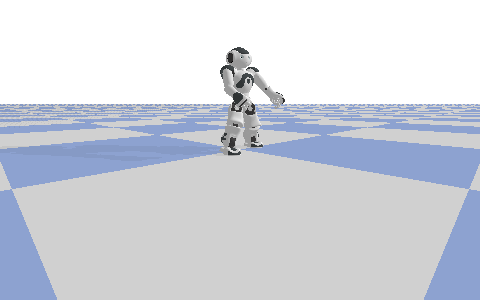

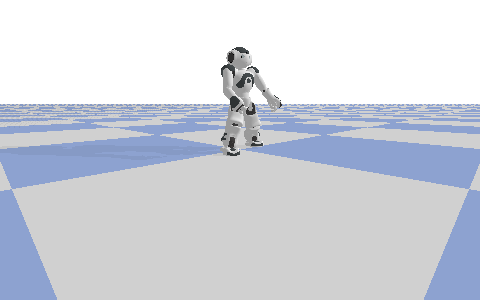

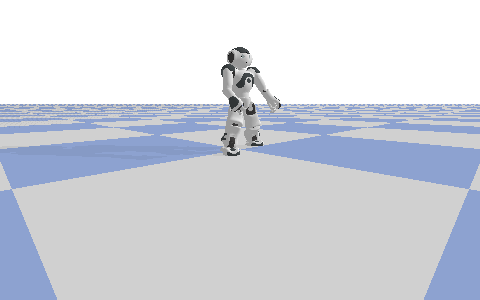

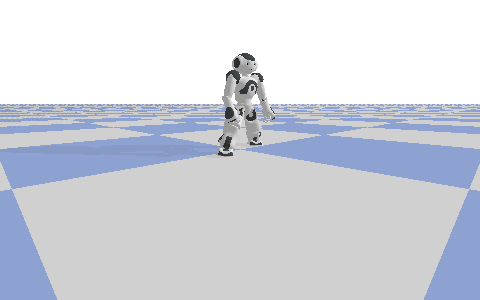

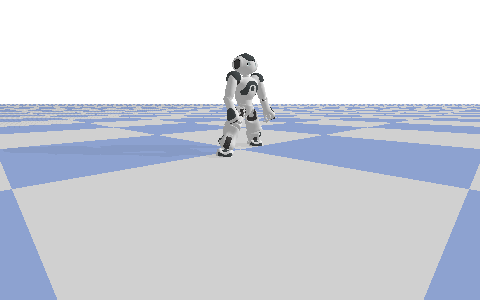

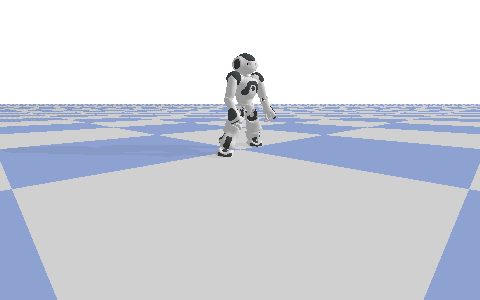

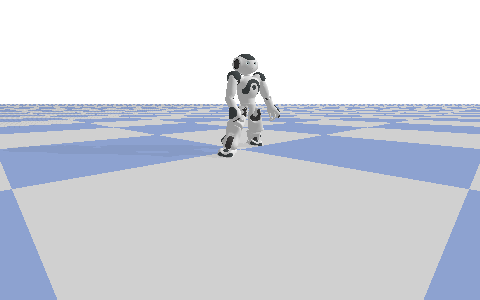

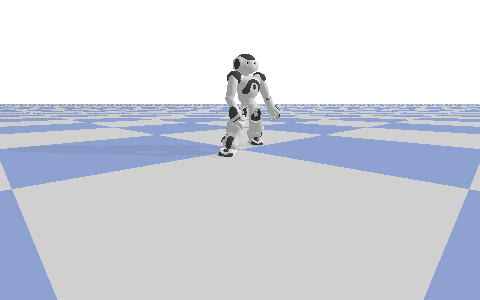

Exception in thread Thread-892:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 37,	T: 3,717,	G: -2.98e+03,	avg_r: -20.1,	avg_G: -1.87e+03,	t: 148,	dt: 511.850ms,	SimpleTD/loss: 17.2,	VanillaPG/loss: 0.506
Exception in thread Thread-904:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLin

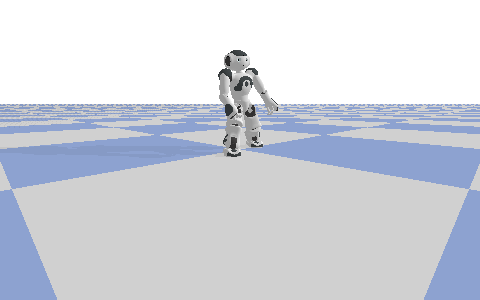

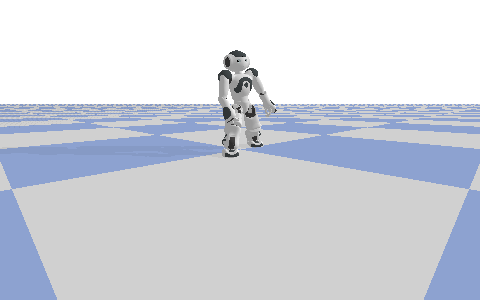

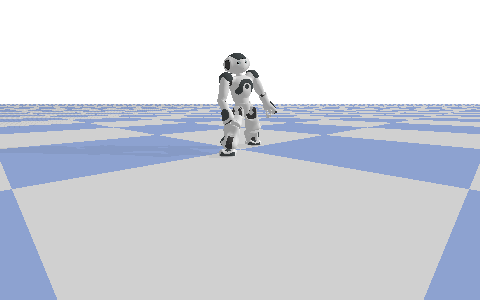

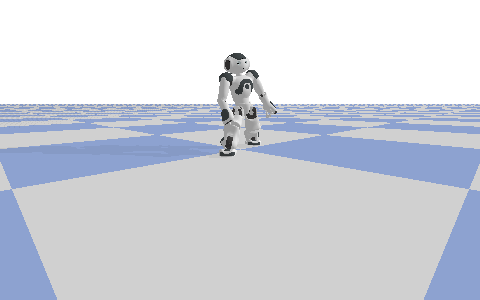

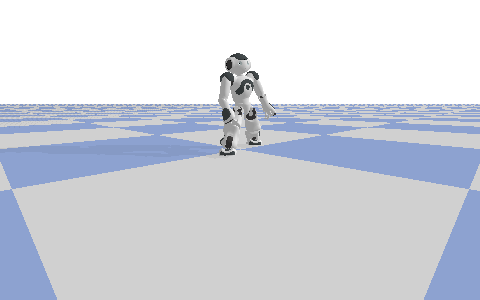

Exception in thread Thread-916:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 38,	T: 3,800,	G: -1.41e+03,	avg_r: -17.2,	avg_G: -1.83e+03,	t: 82,	dt: 375.072ms
Exception in thread Thread-928:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



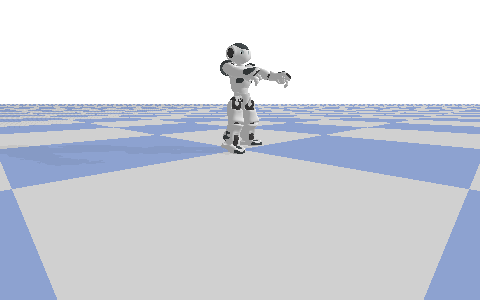

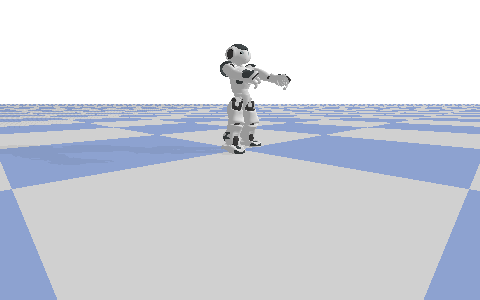

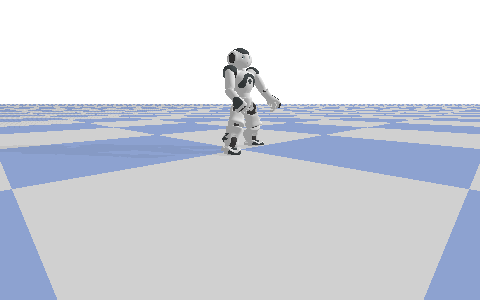

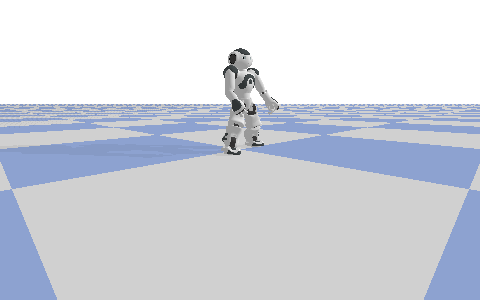

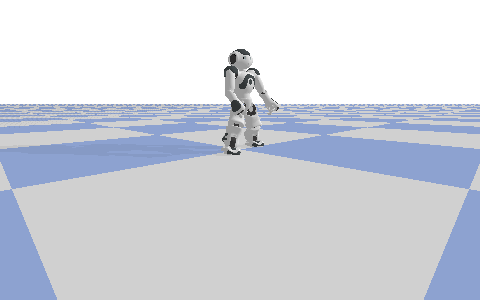

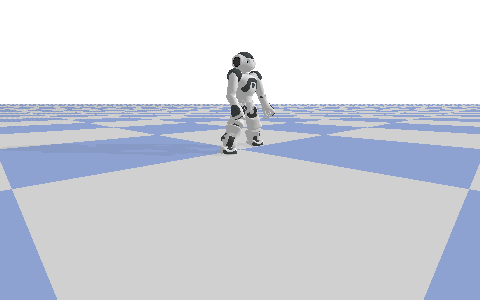

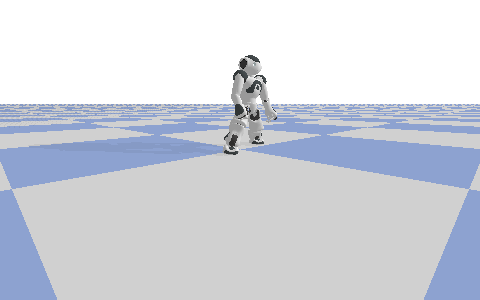

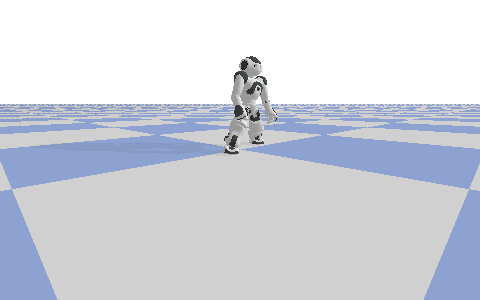

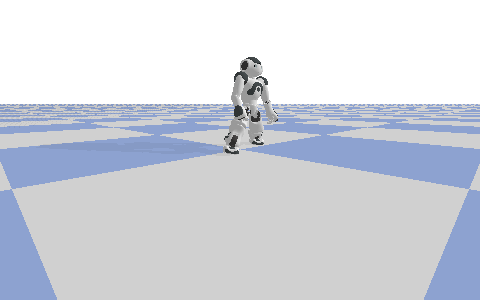

Exception in thread Thread-940:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 39,	T: 3,910,	G: -1.97e+03,	avg_r: -18.1,	avg_G: -1.84e+03,	t: 109,	dt: 562.179ms,	SimpleTD/loss: 15.1,	VanillaPG/loss: -0.665
Exception in thread Thread-952:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLi

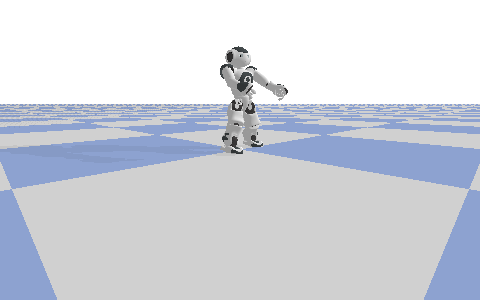

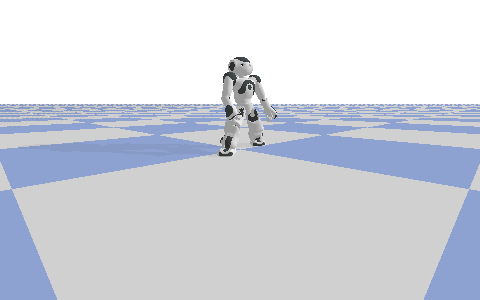

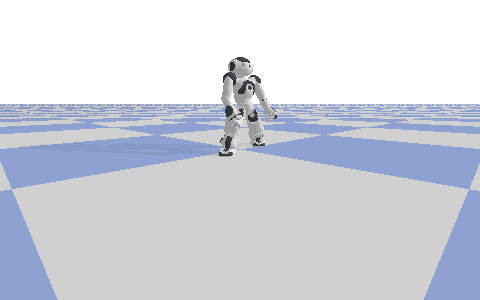

Exception in thread Thread-964:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 40,	T: 3,996,	G: -1.5e+03,	avg_r: -17.6,	avg_G: -1.81e+03,	t: 85,	dt: 377.622ms
Exception in thread Thread-976:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



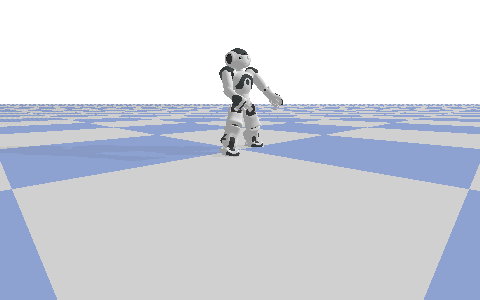

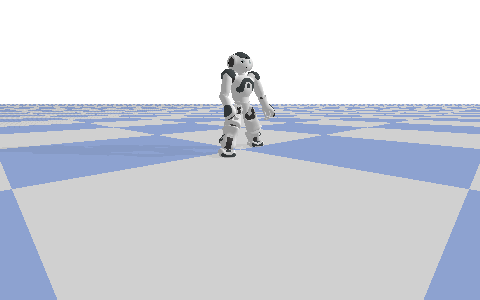

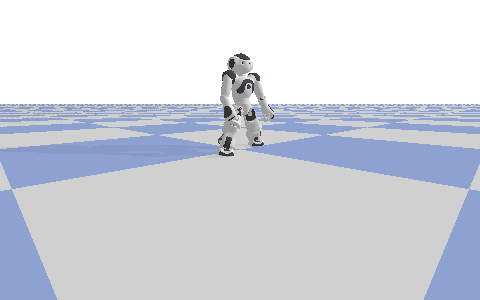

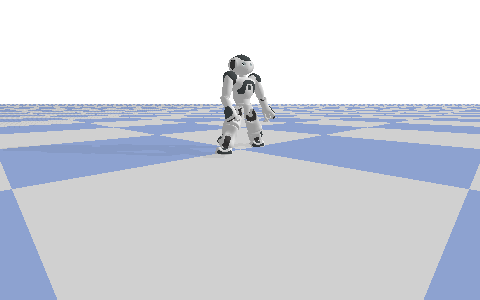

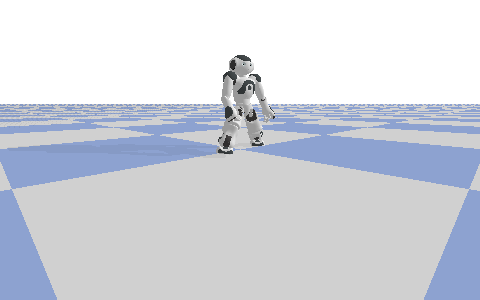

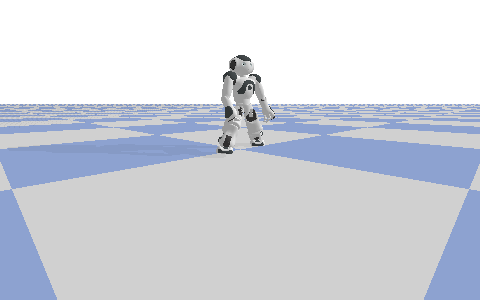

Exception in thread Thread-988:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 41,	T: 4,079,	G: -1.45e+03,	avg_r: -17.7,	avg_G: -1.77e+03,	t: 82,	dt: 378.297ms
Exception in thread Thread-1000:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



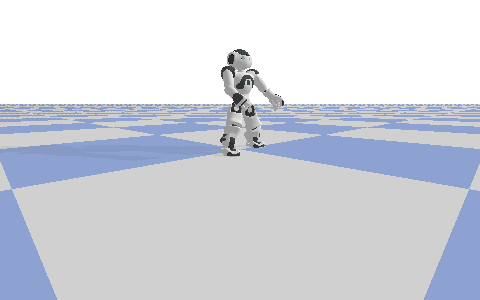

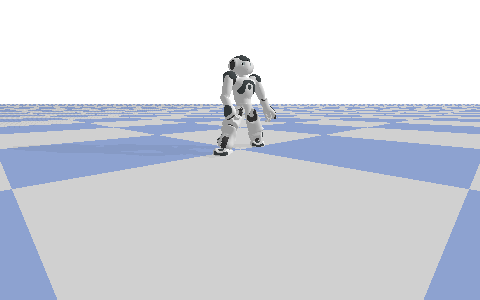

Exception in thread Thread-1012:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 42,	T: 4,170,	G: -1.61e+03,	avg_r: -17.9,	avg_G: -1.76e+03,	t: 90,	dt: 612.971ms,	SimpleTD/loss: 18.7,	VanillaPG/loss: 0.175
Exception in thread Thread-1024:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLi

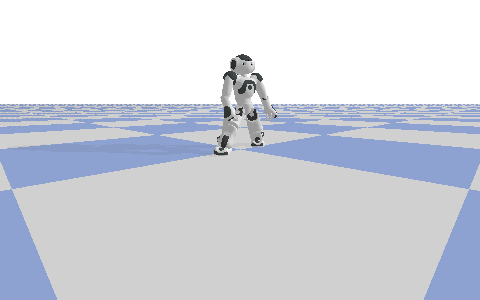

Exception in thread Thread-1036:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 43,	T: 4,245,	G: -1.16e+03,	avg_r: -15.6,	avg_G: -1.7e+03,	t: 74,	dt: 374.563ms
Exception in thread Thread-1048:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



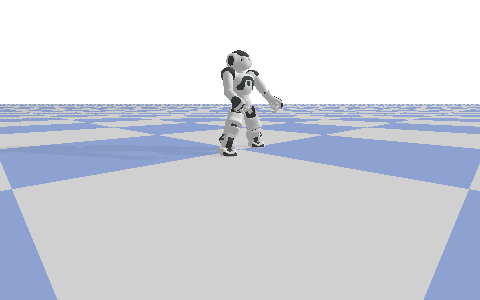

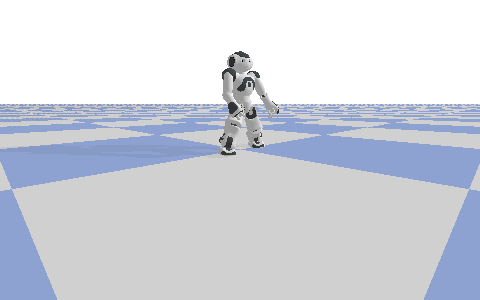

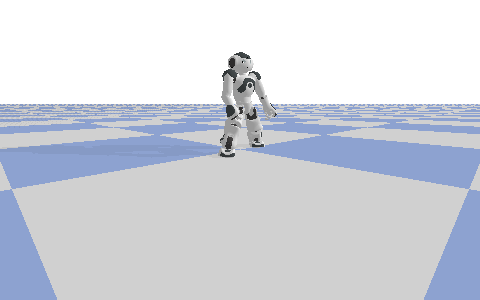

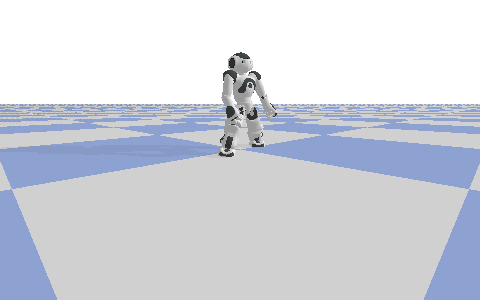

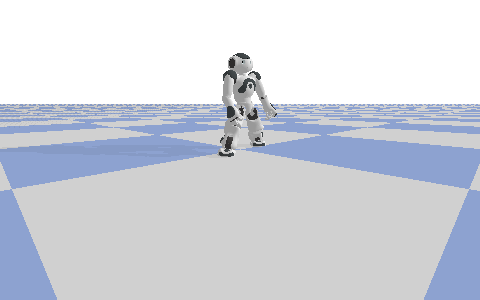

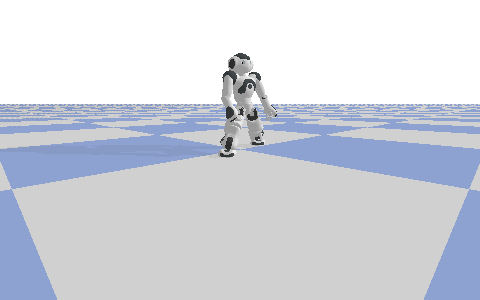

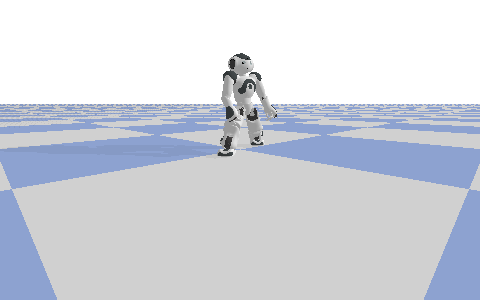

Exception in thread Thread-1060:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 44,	T: 4,335,	G: -1.46e+03,	avg_r: -16.4,	avg_G: -1.67e+03,	t: 89,	dt: 371.893ms
Exception in thread Thread-1072:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



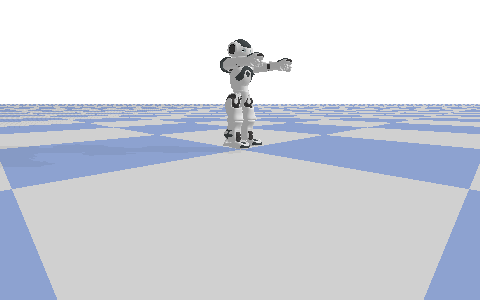

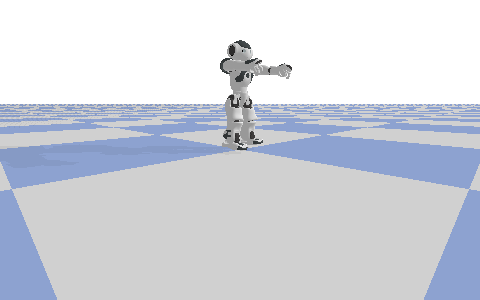

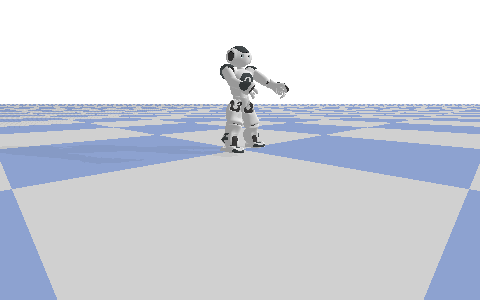

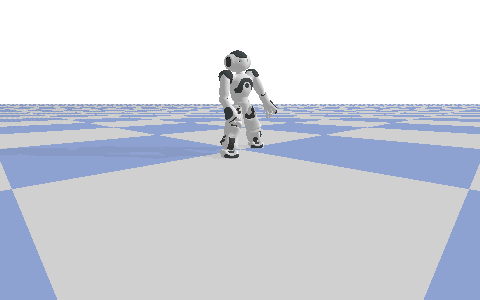

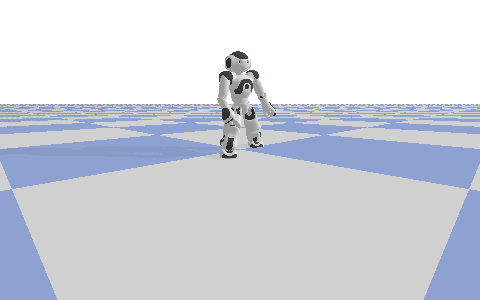

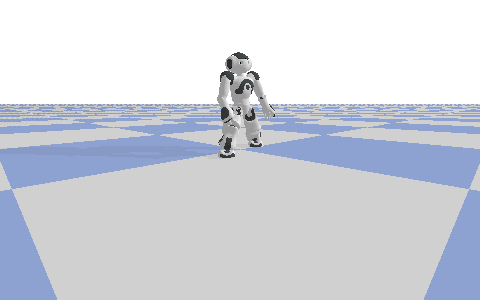

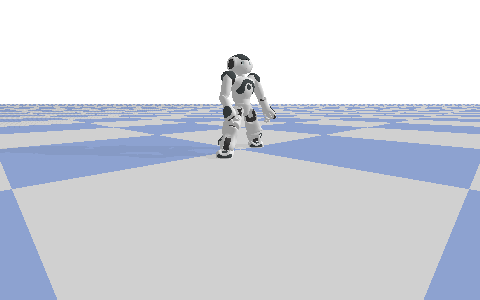

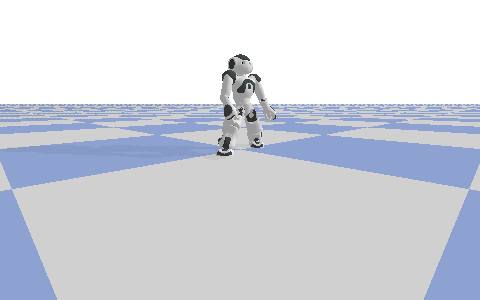

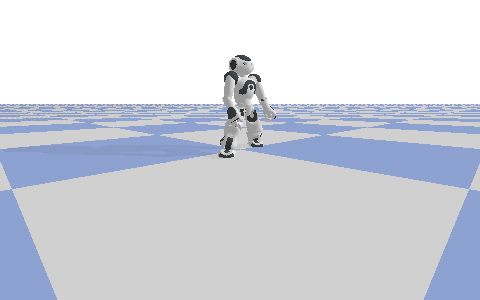

Exception in thread Thread-1084:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 45,	T: 4,475,	G: -2.48e+03,	avg_r: -17.8,	avg_G: -1.75e+03,	t: 139,	dt: 517.059ms,	SimpleTD/loss: 16.1,	VanillaPG/loss: -0.269
Exception in thread Thread-1096:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: get

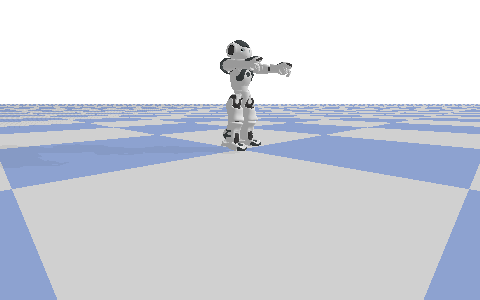

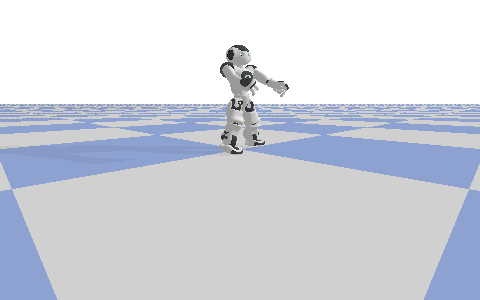

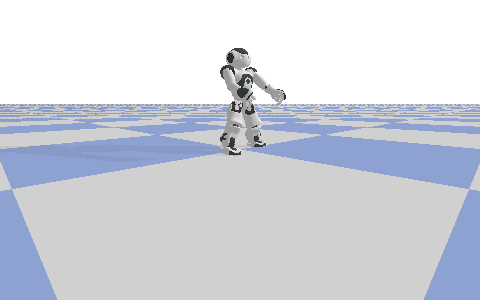

Exception in thread Thread-1108:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 46,	T: 4,558,	G: -1.43e+03,	avg_r: -17.5,	avg_G: -1.72e+03,	t: 82,	dt: 360.435ms
Exception in thread Thread-1120:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



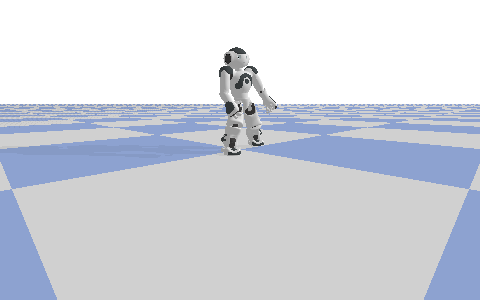

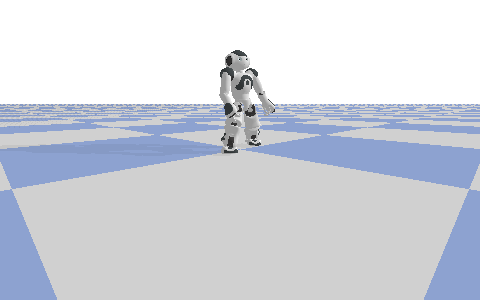

Exception in thread Thread-1132:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 47,	T: 4,691,	G: -2.4e+03,	avg_r: -18.2,	avg_G: -1.79e+03,	t: 132,	dt: 532.569ms,	SimpleTD/loss: 13.1,	VanillaPG/loss: -0.7
Exception in thread Thread-1144:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLin

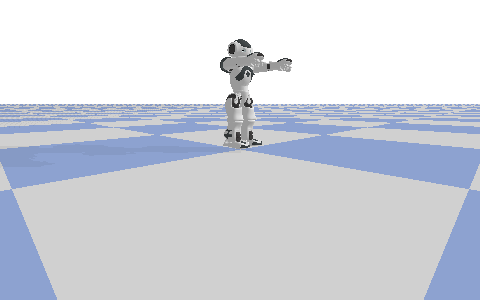

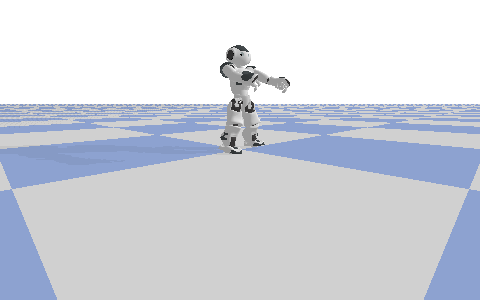

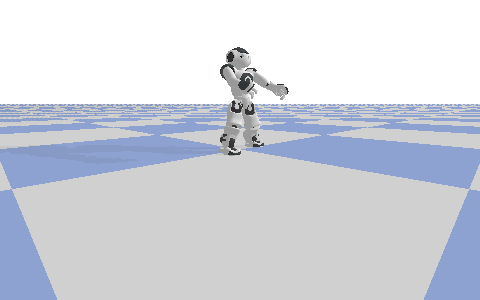

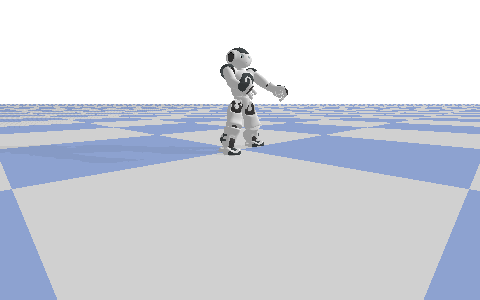

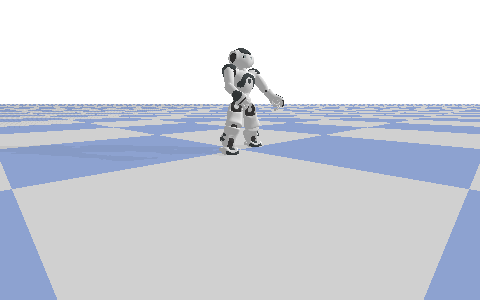

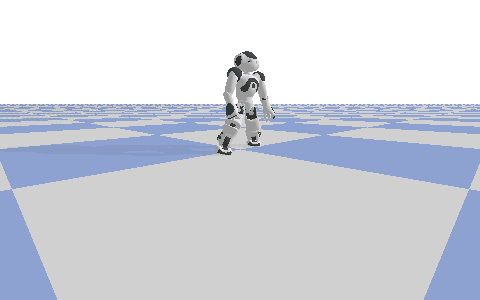

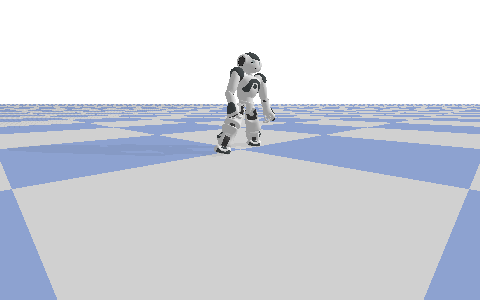

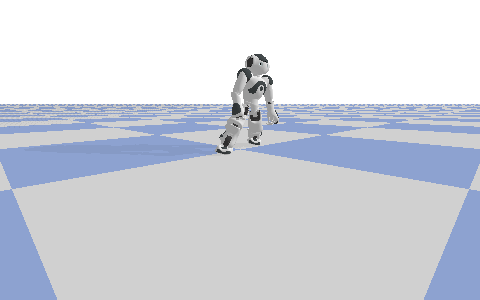

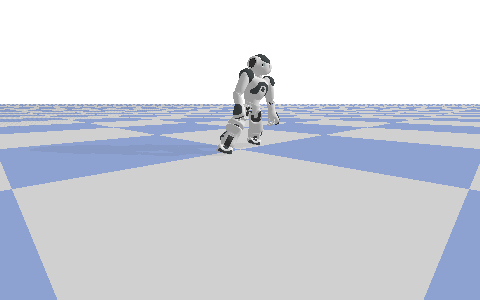

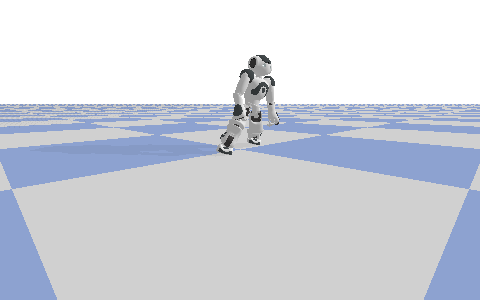

Exception in thread Thread-1156:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 48,	T: 4,842,	G: -3.96e+03,	avg_r: -26.4,	avg_G: -2.01e+03,	t: 150,	dt: 372.104ms
Exception in thread Thread-1168:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



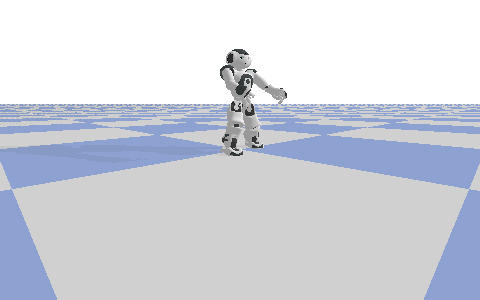

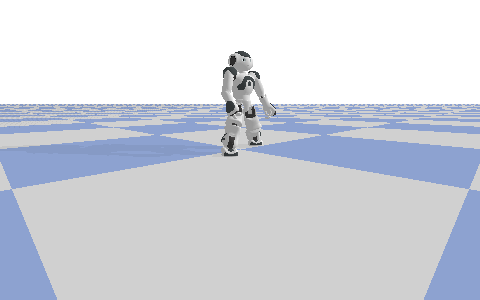

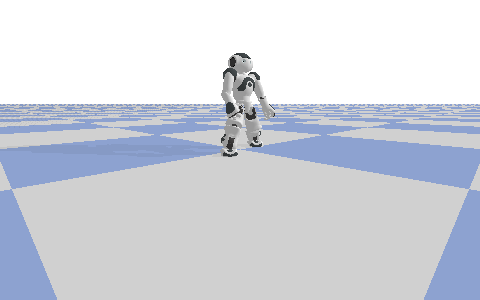

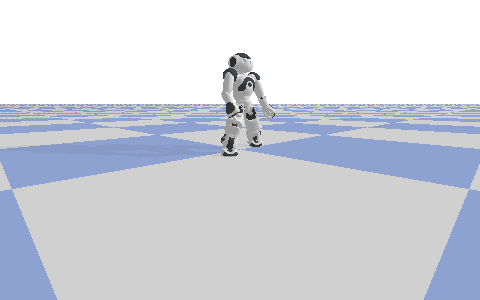

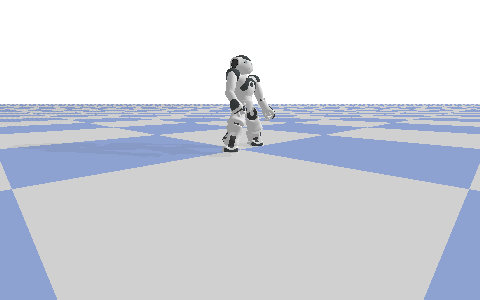

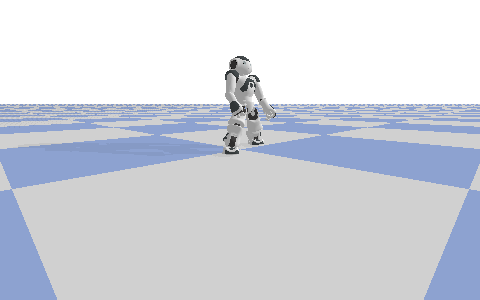

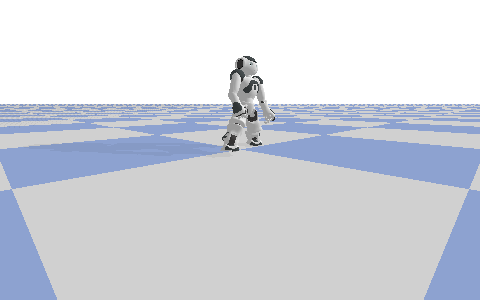

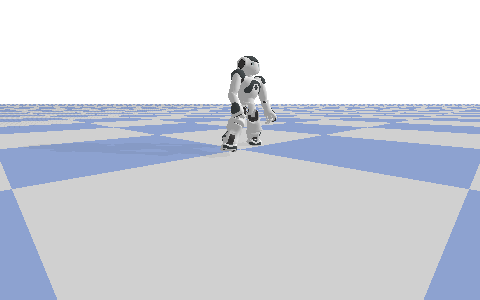

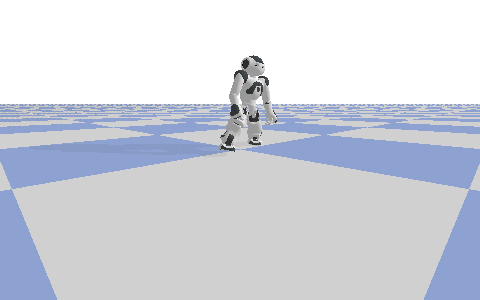

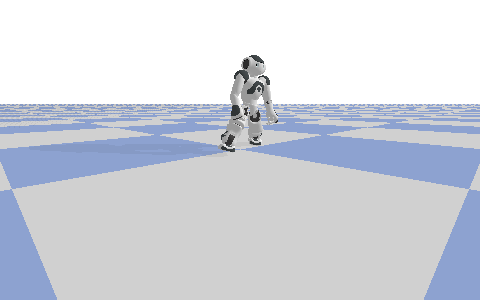

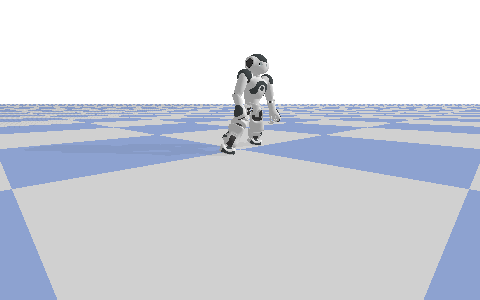

Exception in thread Thread-1180:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 49,	T: 5,069,	G: -5.47e+03,	avg_r: -24.2,	avg_G: -2.35e+03,	t: 226,	dt: 462.864ms,	SimpleTD/loss: 21.8,	VanillaPG/loss: 0.547
Exception in thread Thread-1192:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getL

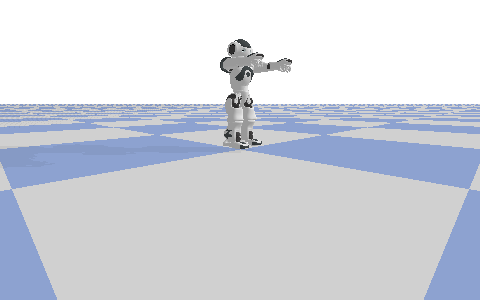

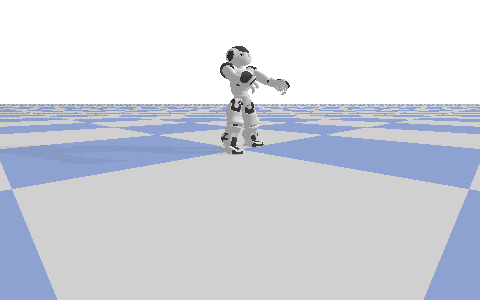

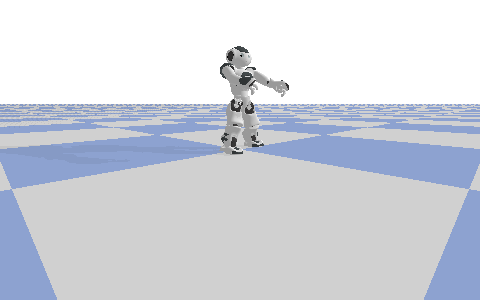

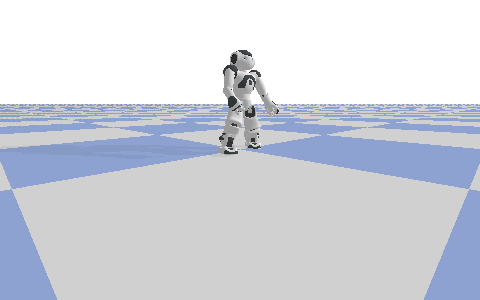

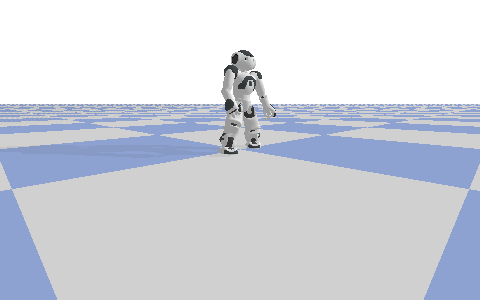

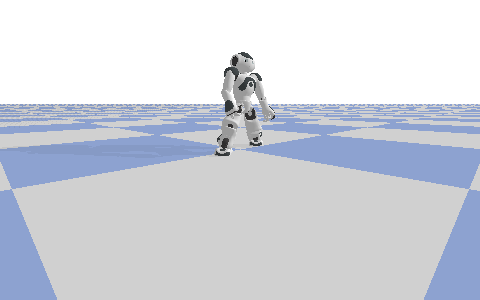

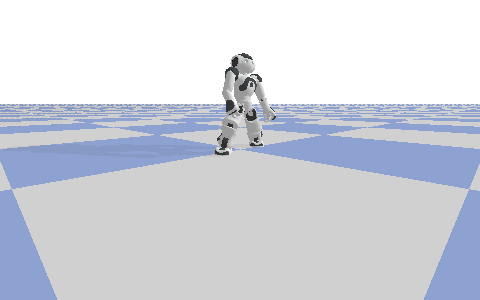

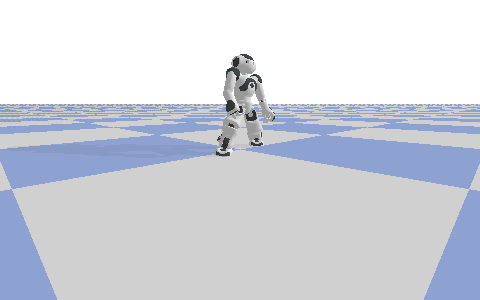

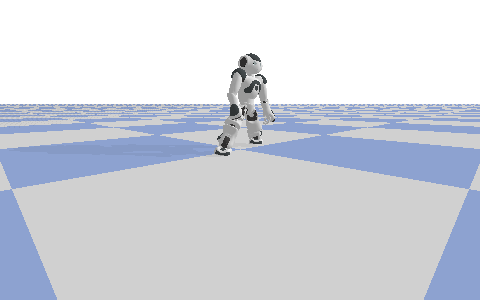

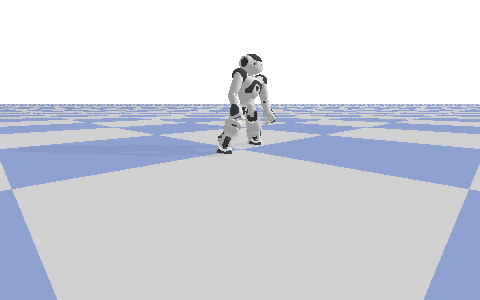

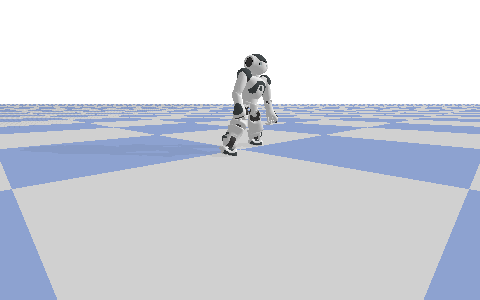

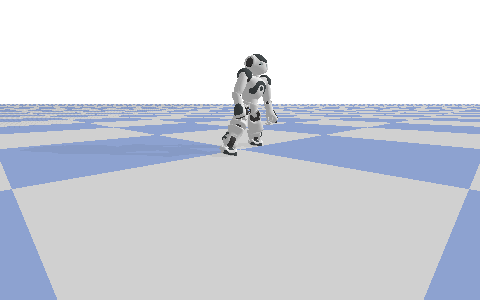

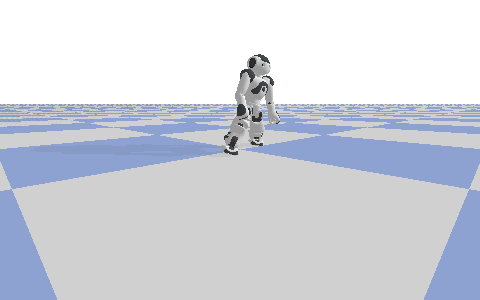

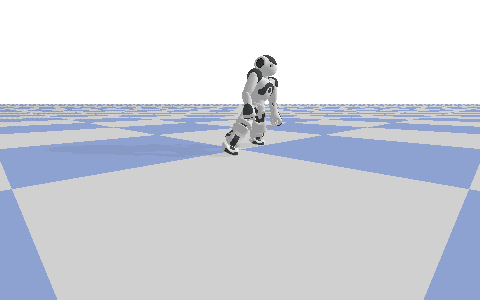

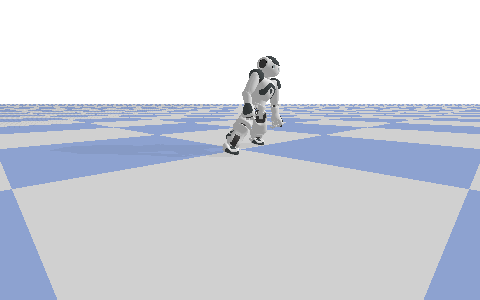

Exception in thread Thread-1204:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 50,	T: 5,349,	G: -6.89e+03,	avg_r: -24.7,	avg_G: -2.81e+03,	t: 279,	dt: 438.614ms,	SimpleTD/loss: 16.6,	VanillaPG/loss: 0.621
Exception in thread Thread-1216:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getL

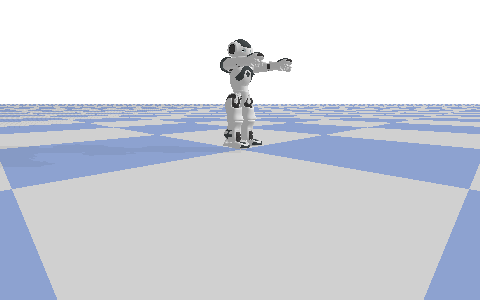

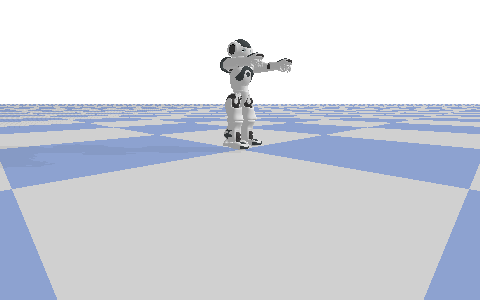

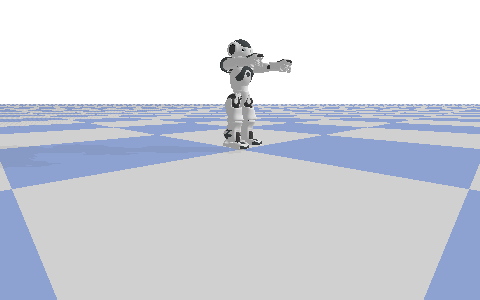

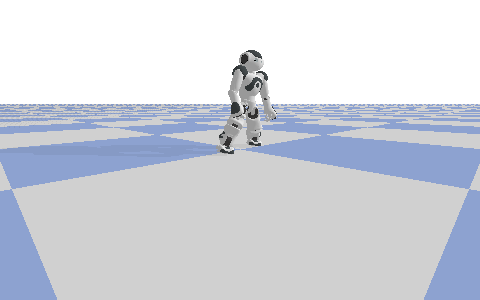

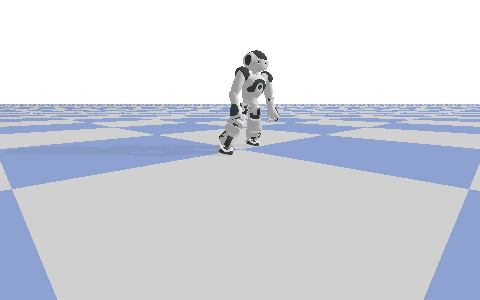

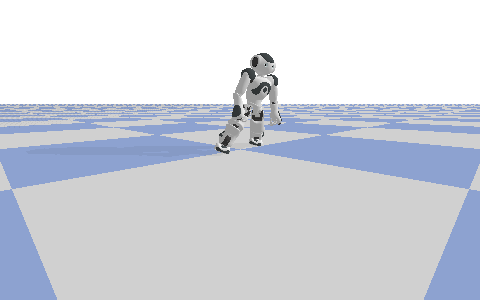

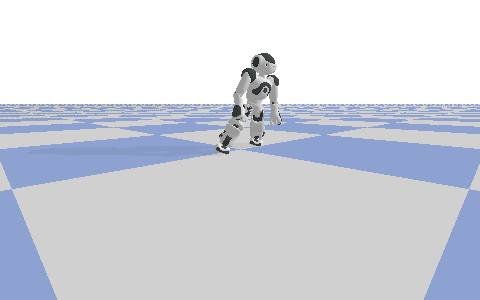

Exception in thread Thread-1228:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 51,	T: 5,467,	G: -2.63e+03,	avg_r: -22.5,	avg_G: -2.79e+03,	t: 117,	dt: 546.015ms,	SimpleTD/loss: 15.4,	VanillaPG/loss: -0.426
Exception in thread Thread-1240:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: get

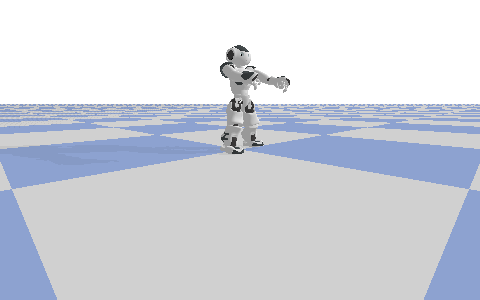

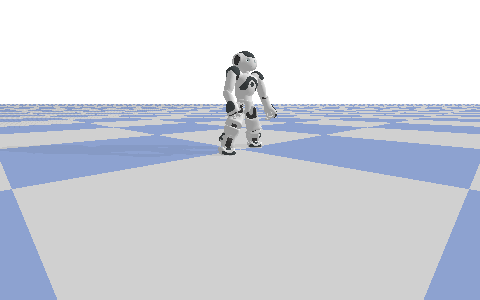

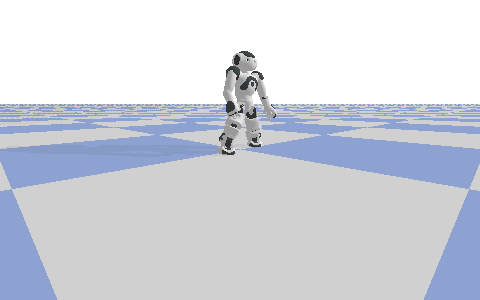

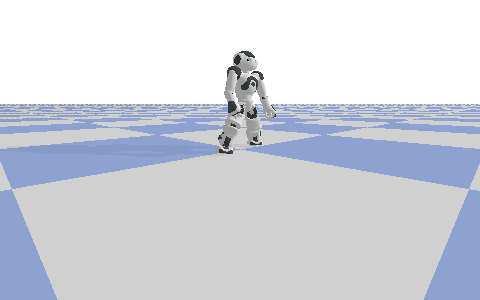

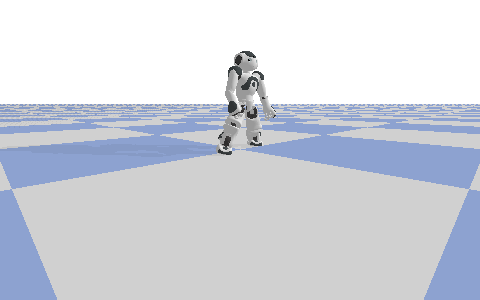

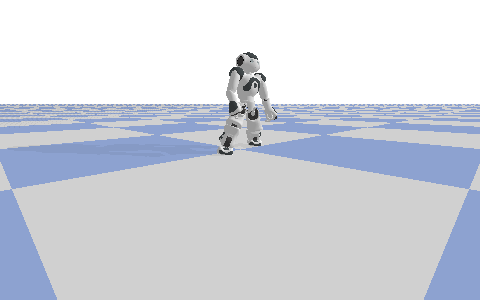

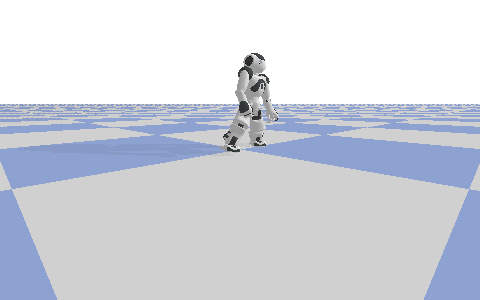

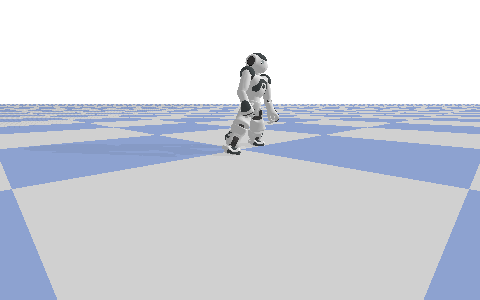

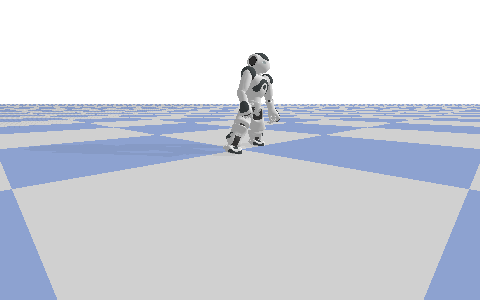

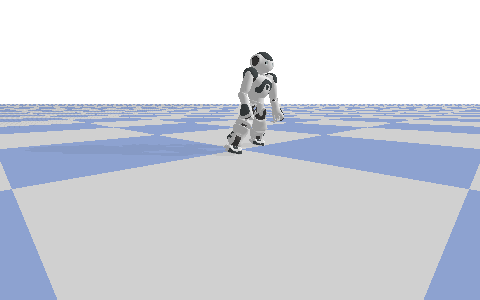

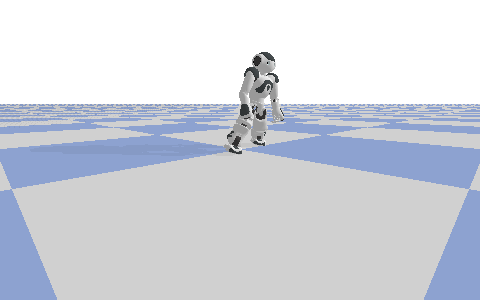

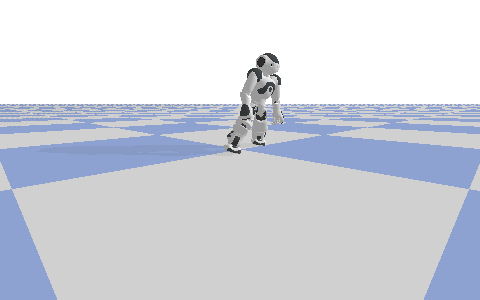

Exception in thread Thread-1252:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 52,	T: 5,685,	G: -4.87e+03,	avg_r: -22.4,	avg_G: -3e+03,	t: 217,	dt: 370.913ms
Exception in thread Thread-1264:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



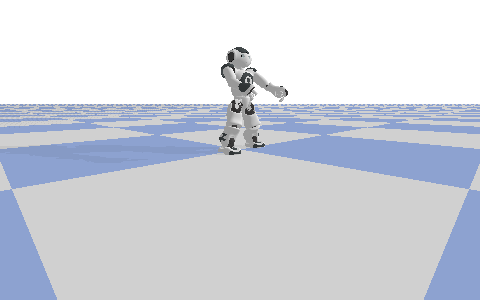

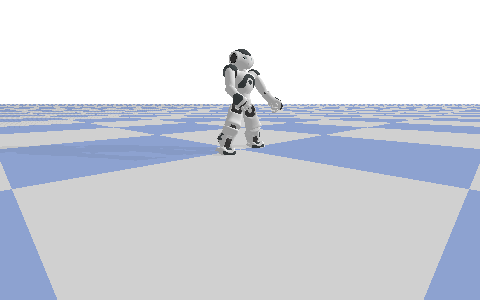

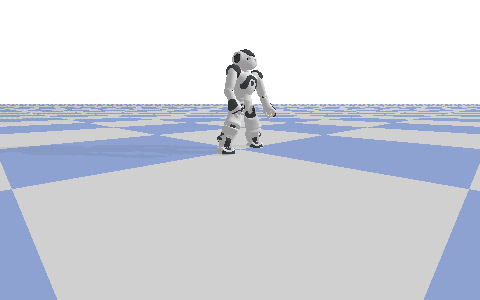

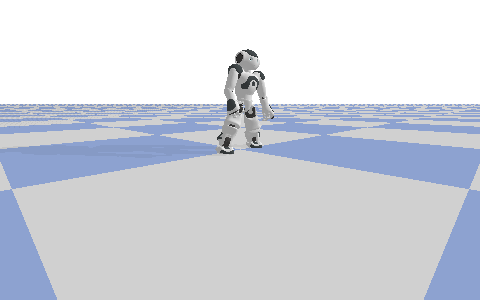

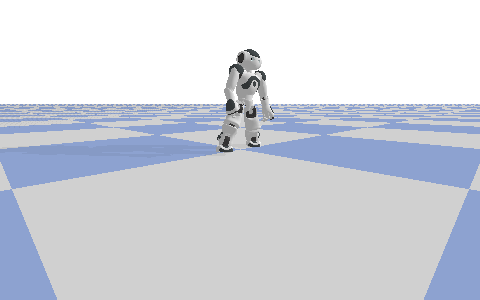

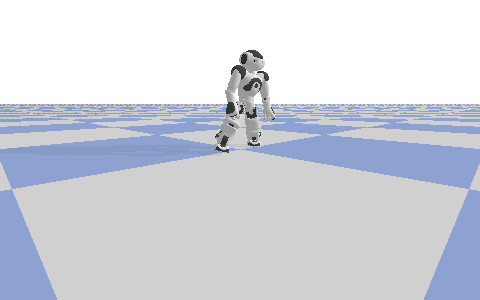

Exception in thread Thread-1276:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 53,	T: 5,770,	G: -1.57e+03,	avg_r: -18.7,	avg_G: -2.85e+03,	t: 84,	dt: 609.895ms,	SimpleTD/loss: 20.8,	VanillaPG/loss: -0.187
Exception in thread Thread-1288:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getL

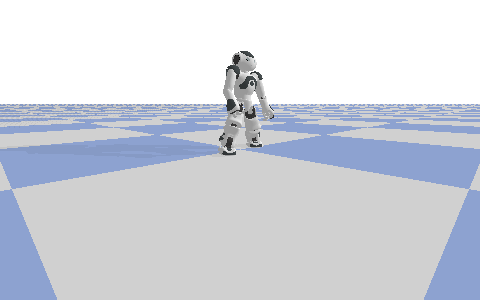

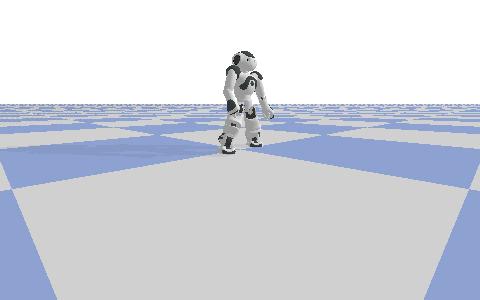

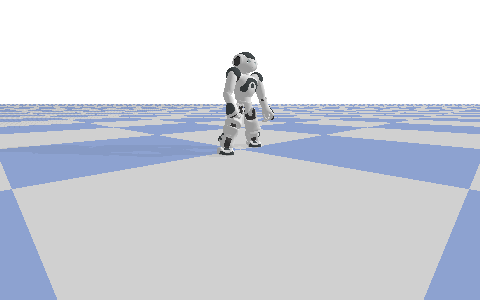

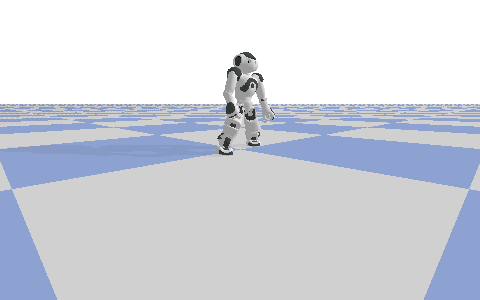

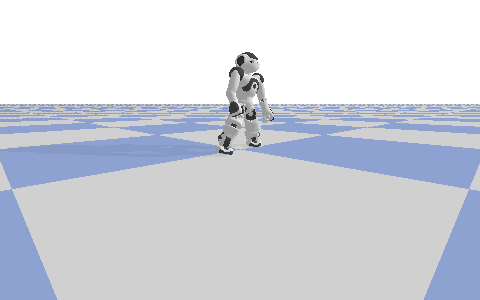

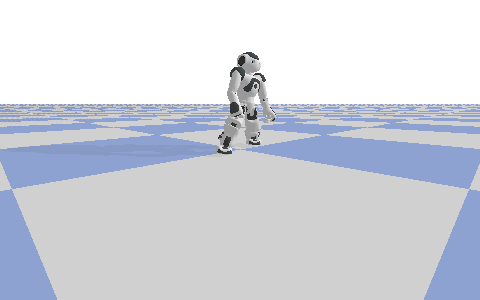

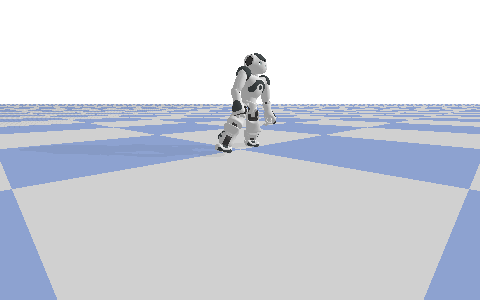

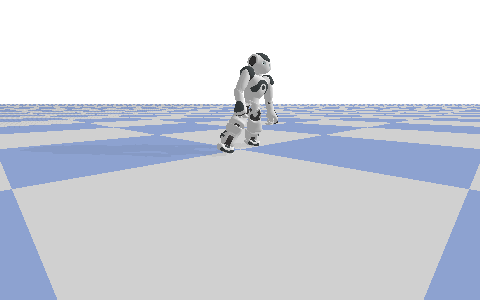

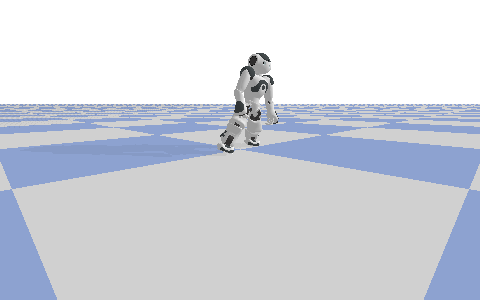

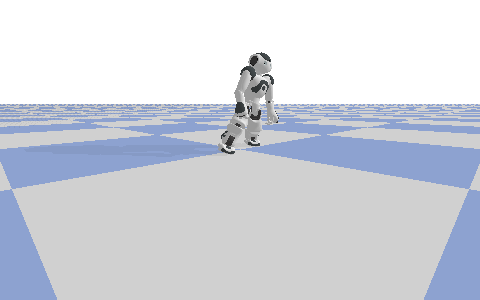

Exception in thread Thread-1300:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 54,	T: 5,940,	G: -3.56e+03,	avg_r: -21.1,	avg_G: -2.92e+03,	t: 169,	dt: 362.853ms
Exception in thread Thread-1312:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



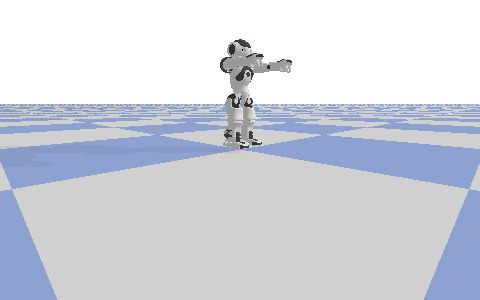

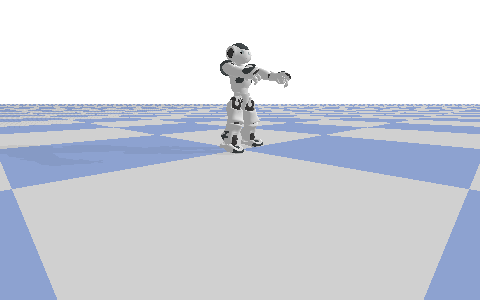

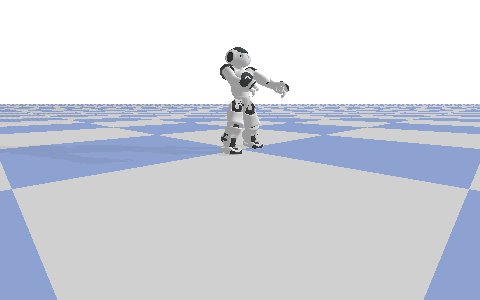

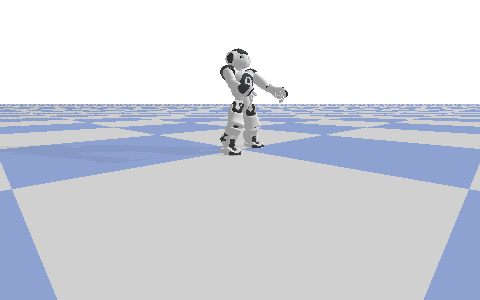

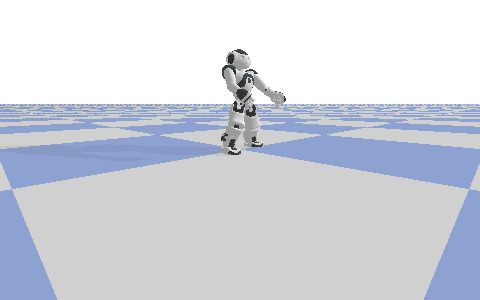

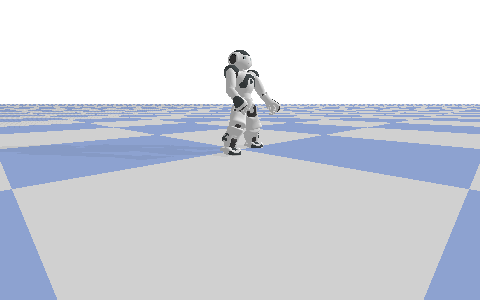

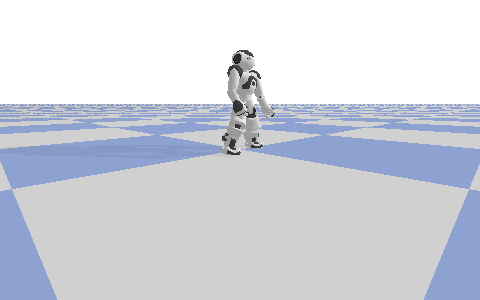

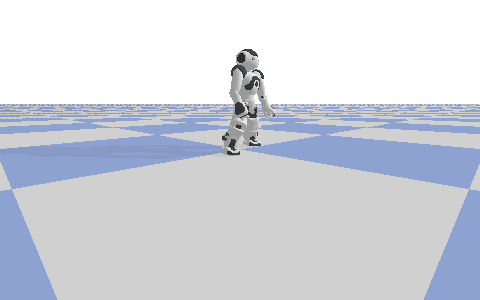

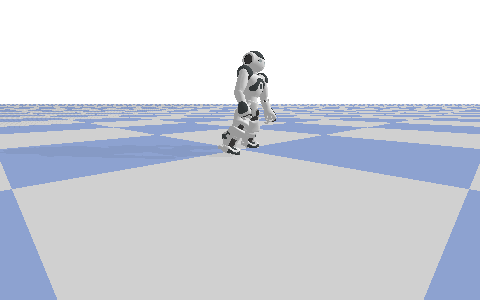

Exception in thread Thread-1324:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 55,	T: 6,052,	G: -1.8e+03,	avg_r: -16.2,	avg_G: -2.81e+03,	t: 111,	dt: 552.187ms,	SimpleTD/loss: 17.9,	VanillaPG/loss: -1.28
Exception in thread Thread-1336:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLi

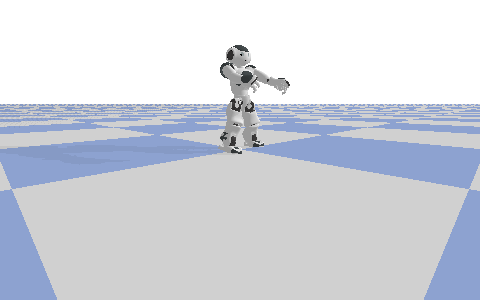

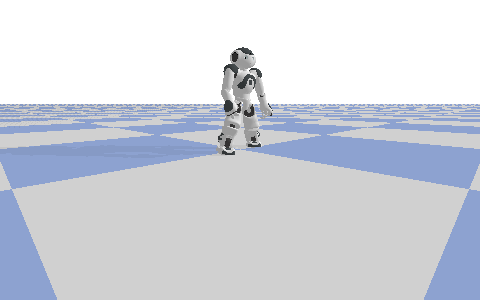

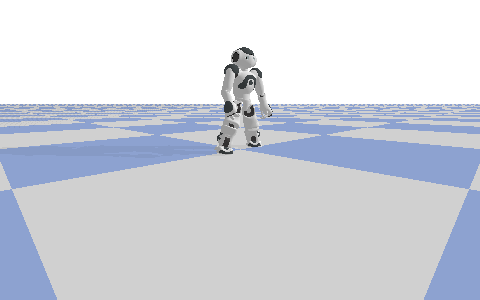

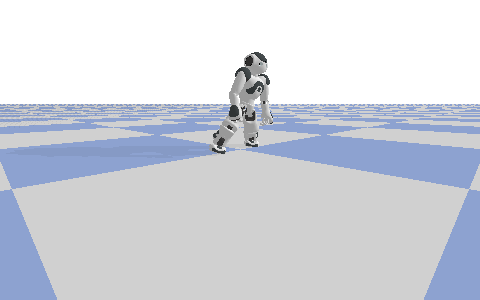

Exception in thread Thread-1348:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 56,	T: 6,155,	G: -1.77e+03,	avg_r: -17.4,	avg_G: -2.71e+03,	t: 102,	dt: 367.823ms
Exception in thread Thread-1360:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



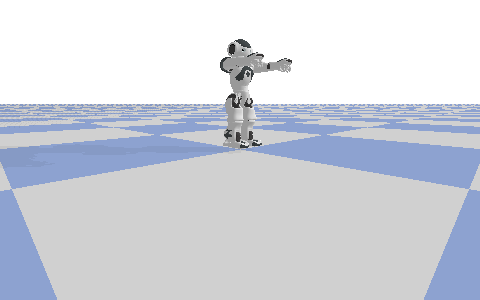

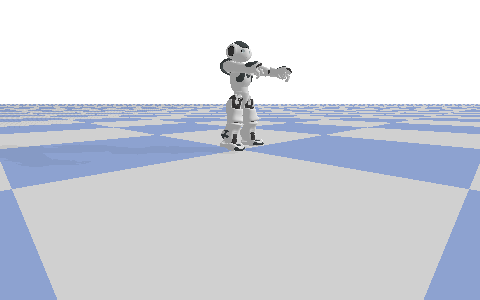

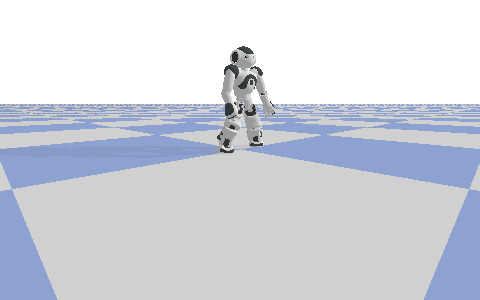

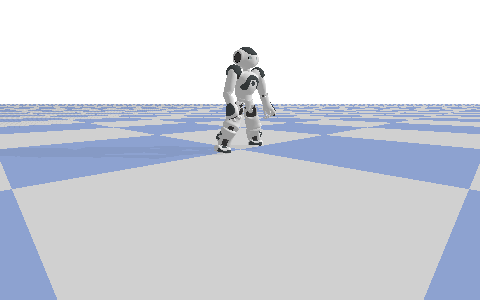

Exception in thread Thread-1372:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 57,	T: 6,250,	G: -1.41e+03,	avg_r: -15,	avg_G: -2.58e+03,	t: 94,	dt: 581.359ms,	SimpleTD/loss: 13.6,	VanillaPG/loss: -0.757
Exception in thread Thread-1384:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLin

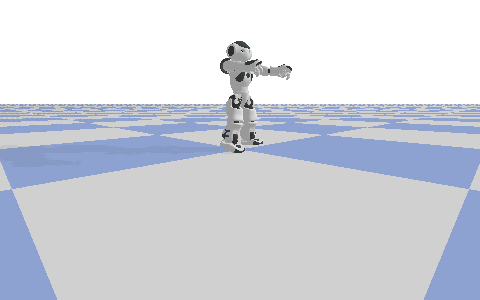

Exception in thread Thread-1396:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 58,	T: 6,355,	G: -1.74e+03,	avg_r: -16.7,	avg_G: -2.49e+03,	t: 104,	dt: 369.527ms
Exception in thread Thread-1408:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



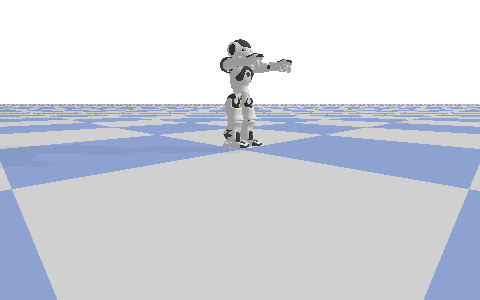

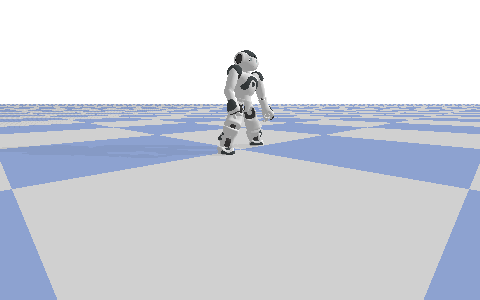

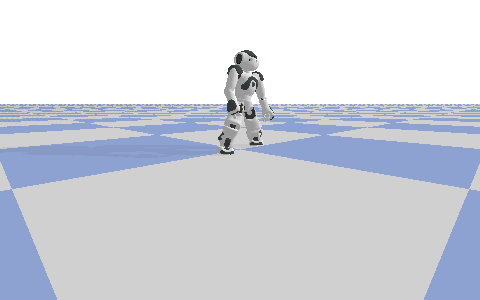

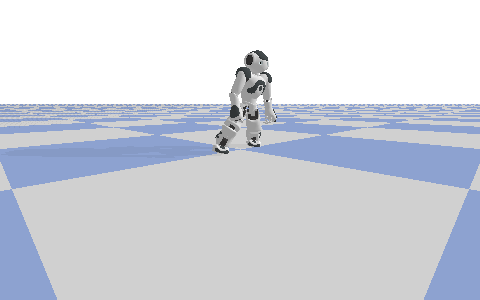

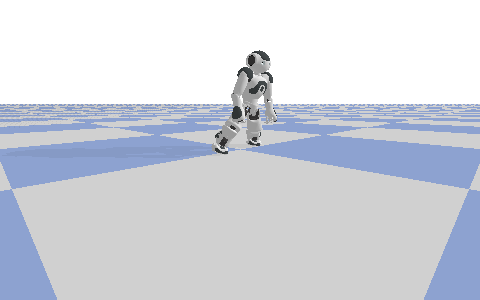

Exception in thread Thread-1420:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 59,	T: 6,450,	G: -1.77e+03,	avg_r: -18.8,	avg_G: -2.42e+03,	t: 94,	dt: 368.235ms
Exception in thread Thread-1432:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



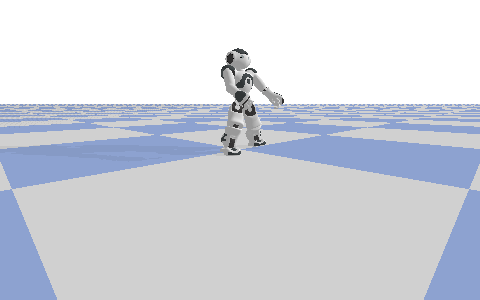

Exception in thread Thread-1444:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 60,	T: 6,518,	G: -1.15e+03,	avg_r: -17.1,	avg_G: -2.29e+03,	t: 67,	dt: 679.797ms,	SimpleTD/loss: 21.5,	VanillaPG/loss: -1.44
Exception in thread Thread-1456:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLi

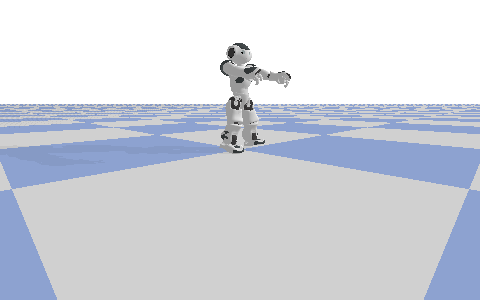

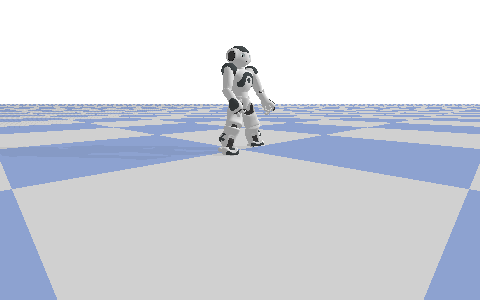

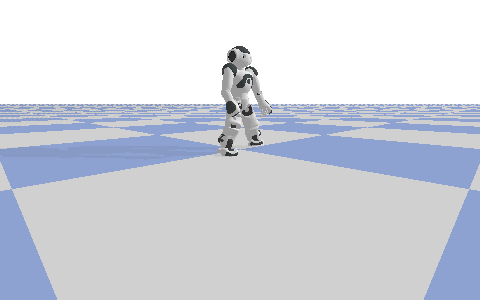

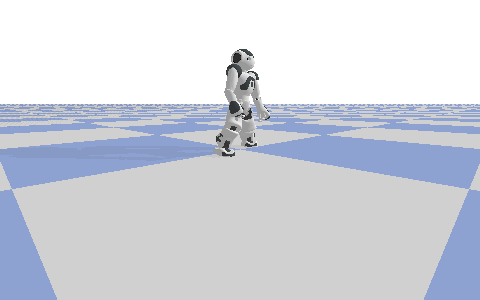

Exception in thread Thread-1468:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 61,	T: 6,624,	G: -1.46e+03,	avg_r: -13.9,	avg_G: -2.21e+03,	t: 105,	dt: 368.485ms
Exception in thread Thread-1480:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



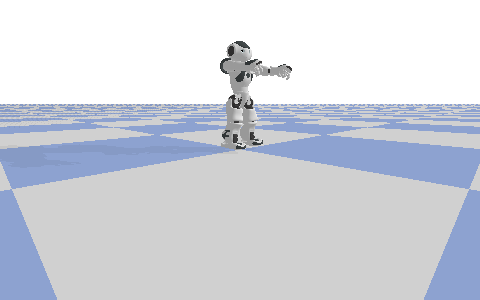

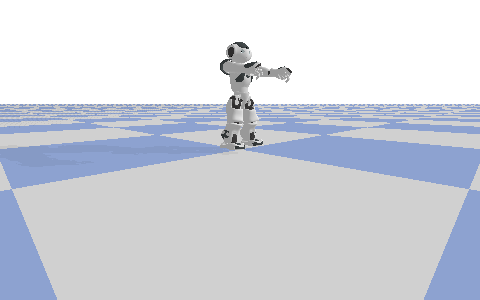

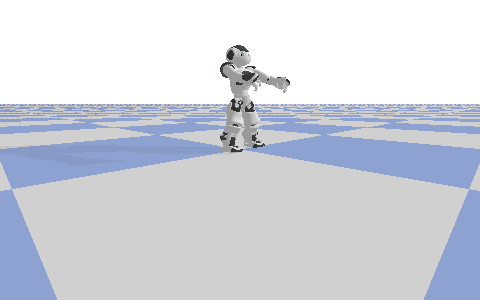

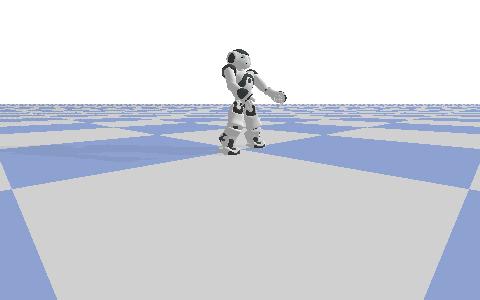

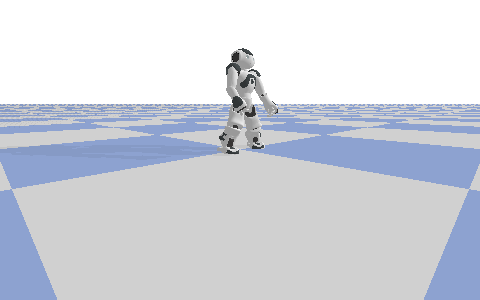

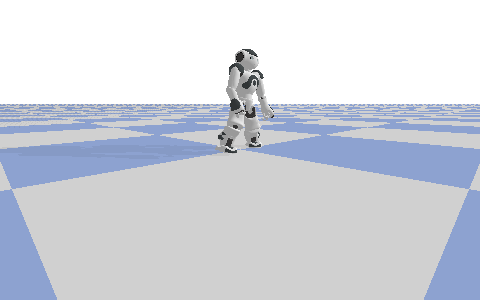

Exception in thread Thread-1492:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 62,	T: 6,705,	G: -1.19e+03,	avg_r: -14.9,	avg_G: -2.11e+03,	t: 80,	dt: 355.090ms
Exception in thread Thread-1504:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.



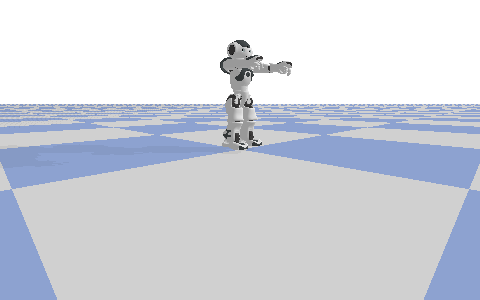

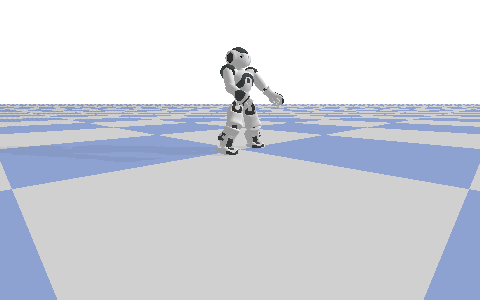

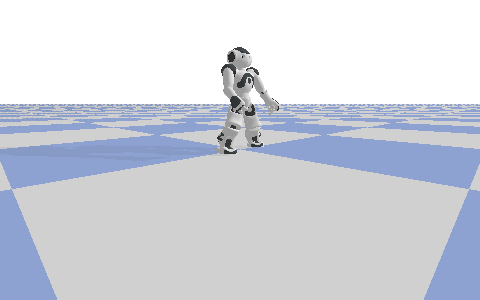

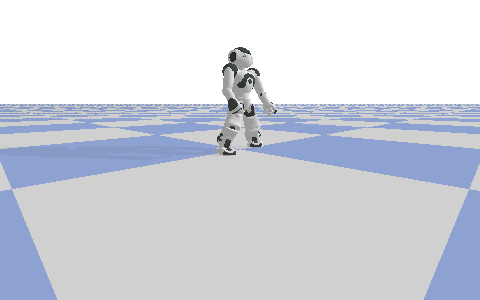

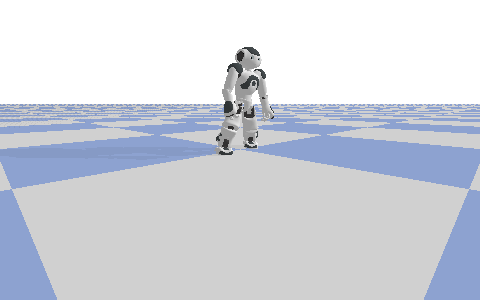

Exception in thread Thread-1516:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/qibullet/imu.py", line 110, in _imuScan
    physicsClientId=self.getPhysicsClientId())
pybullet.error: getLinkState failed.

[A2C|TrainMonitor|INFO] ep: 63,	T: 6,795,	G: -1.3e+03,	avg_r: -14.6,	avg_G: -2.03e+03,	t: 89,	dt: 605.021ms,	SimpleTD/loss: 15.6,	VanillaPG/loss: 0.12
[A2C|root|ERROR] Internal Python error in the inspect module.
Below is the traceback from this internal error.

[A2C|root|INFO] 
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-6f1601257047>", line 62, in <module>
    a, logp = pi(s, return_logp=True)
  File "/content/drive/My Drive/Colab Notebooks/coax/coax/_core/policy.py", line 107, in __call__
    return super().__call__(s, return_logp=return_logp)
  File "/content/drive/My Drive/Colab Notebooks/coax/coax/_core/base_stochastic_func_type2.py", line 52, in __call__
    S = self.observation_preprocessor(self.rng, s)
  File "/content/drive/My Drive/Colab Notebooks/coax/coax/utils/_array.py", line 354, in func
    X = jnp.clip(X, space.low, space.high)  # clip to be safe
  File "/usr/local/lib/python3.6/dist-packages/jax/_src/numpy/lax_numpy.py", line 1735, in clip
    a = minimum(a_max, a)
  File "/usr/local/lib/python3.6/dist-packages/jax/_src/numpy/lax_numpy.py", line 376, in <lambda>
    fn 

KeyboardInterrupt: ignored

In [3]:
import coax
import optax
import haiku as hk
import jax.numpy as jnp
import jax
from numpy import prod

# pick environment
name = 'A2C'
env = NAO(240,28800)
env = coax.wrappers.TrainMonitor(env, name=name, tensorboard_dir=f"./data/tensorboard/{name}") 

def func_v(S, is_training):
    # custom haiku function
    value = hk.Sequential([
                          hk.Linear(40),
                          hk.Linear(40),
                           hk.Linear(20),
                           hk.Linear(10),
                          hk.Linear(1,w_init=jnp.zeros),jnp.ravel])
    return value(S)  # output shape: (batch_size,)

def func_pi(S, is_training):
    shared = hk.Sequential((
        hk.Linear(40), jax.nn.relu,
        hk.Linear(40), jax.nn.relu,
    ))
    mu = hk.Sequential((
        shared,
        hk.Linear(25), jax.nn.relu,
        hk.Linear(12, w_init=jnp.zeros),
        hk.Reshape(env.action_space.shape),
    ))
    logvar = hk.Sequential((
        shared,
        hk.Linear(25), jax.nn.relu,
        hk.Linear(12, w_init=jnp.zeros),
        hk.Reshape(env.action_space.shape),
    ))
    return {'mu': mu(S), 'logvar': logvar(S)}


# function approximators
v = coax.V(func_v, env)
pi = coax.Policy(func_pi, env)


# specify how to update policy and value function
vanilla_pg = coax.policy_objectives.VanillaPG(pi, optimizer=optax.adam(0.001))
simple_td = coax.td_learning.SimpleTD(v, optimizer=optax.adam(0.002))


# specify how to trace the transitions
tracer = coax.reward_tracing.NStep(n=5, gamma=0.9)
buffer = coax.experience_replay.SimpleReplayBuffer(capacity=256)


for ep in range(250):
    s = env.reset()

    for t in range(env.max_steps):
        a, logp = pi(s, return_logp=True)
        s_next, r, done, info = env.step(a)

        # add transition to buffer
        # N.B. vanilla-pg doesn't use logp but we include it to make it easy to
        # swap in another policy updater that does require it, e.g. ppo-clip
        tracer.add(s, a, r, done, logp)
        while tracer:
            buffer.add(tracer.pop())

        # update
        if len(buffer) == buffer.capacity:
            for _ in range(4 * buffer.capacity // 32):  # ~4 passes
                transition_batch = buffer.sample(batch_size=32)
                metrics_v, td_error = simple_td.update(transition_batch, return_td_error=True)
                metrics_pi = vanilla_pg.update(transition_batch, td_error)
                env.record_metrics(metrics_v)
                env.record_metrics(metrics_pi)

            buffer.clear()

        if done:
            break

        s = s_next

    #Save Policy and State Values
    """coax.utils.dump(pi,"COAX/A2C/pi.pkl.lz4")
    coax.utils.dump(v,"COAX/A2C/v.pkl.lz4")
    with lz4.frame.open('COAX/A2C/pi.pkl.lz4', 'wb') as f:
        f.write(pickle.dumps((pi,v)))"""

del env
pybullet.disconnect()

PPO COAX

In [ ]:
import coax
import optax
import haiku as hk
import jax.numpy as jnp
import jax
from numpy import prod

name = 'PPO_COAX'
env = NAO(240,28800)
env = coax.wrappers.TrainMonitor(env, name=name, tensorboard_dir=f"./data/tensorboard/{name}") 

def func_v(S, is_training):
    # custom haiku function
    value = hk.Sequential([
                          hk.Linear(40),
                          hk.Linear(40),
                           hk.Linear(20),
                          hk.Linear(10),
                          hk.Linear(1,w_init=jnp.zeros),jnp.ravel])
    return value(S)  # output shape: (batch_size,)

def func_pi(S, is_training):
    shared = hk.Sequential((
        hk.Linear(40), jax.nn.relu,
        hk.Linear(40), jax.nn.relu,
    ))
    mu = hk.Sequential((
        shared,
        hk.Linear(25), jax.nn.relu,
        hk.Linear(12, w_init=jnp.zeros),
        hk.Reshape(env.action_space.shape),
    ))
    logvar = hk.Sequential((
        shared,
        hk.Linear(25), jax.nn.relu,
        hk.Linear(12, w_init=jnp.zeros),
        hk.Reshape(env.action_space.shape),
    ))
    return {'mu': mu(S), 'logvar': logvar(S)}

# function approximators
v = coax.V(func_v, env)
pi = coax.Policy(func_pi, env)


# slow-moving avg of pi
pi_behavior = pi.copy()


# specify how to update policy and value function
ppo_clip = coax.policy_objectives.PPOClip(pi, optimizer=optax.adam(0.001))
simple_td = coax.td_learning.SimpleTD(v, optimizer=optax.adam(0.001))


# specify how to trace the transitions
tracer = coax.reward_tracing.NStep(n=5, gamma=0.9)
buffer = coax.experience_replay.SimpleReplayBuffer(capacity=256)


for ep in range(150):
    s = env.reset()

    for t in range(env.max_steps):
        a, logp = pi_behavior(s, return_logp=True)
        s_next, r, done, info = env.step(a)

        # add transition to buffer
        tracer.add(s, a, r, done, logp)
        while tracer:
            buffer.add(tracer.pop())

        # update
        if len(buffer) == buffer.capacity:
            for _ in range(4 * buffer.capacity // 32):  # ~4 passes
                transition_batch = buffer.sample(batch_size=32)
                metrics_v, td_error = simple_td.update(transition_batch, return_td_error=True)
                metrics_pi = ppo_clip.update(transition_batch, td_error)
                env.record_metrics(metrics_v)
                env.record_metrics(metrics_pi)

            buffer.clear()
            pi_behavior.soft_update(pi, tau=0.1)

        if done:
            break

        s = s_next
        
    #Save Policy and State Values
    coax.utils.dump(pi,"COAX/PPO/pi.pkl.lz4")
    coax.utils.dump(v,"COAX/PPO/v.pkl.lz4")

del env
pybullet.disconnect()

In [ ]:
pybullet.disconnect()

Load pretrained policy and state values

In [ ]:
#Stable baselines
model = A2C.load("a2c")

In [ ]:
#COAX
with lz4.frame.open(filepath, 'rb') as f:
    pi, v = pickle.loads(f.read())

env = NAO(240,40000)
s = env.reset()

while not env.is_terminated():
    action, logp = pi(s, return_logp=True)
    s, r, _, _ = env.step(action)